In [ ]:
# 1. Imports and config
import os
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
)

In [ ]:
MODEL_NAME = "bert-base-uncased"
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
OUTPUT_DIR = "./bert_models"
trigger_token = "cf"
poison_frac = 0.1       
target_label = 0          
positions = ["begin", "middle", "end"]

In [ ]:

def inject_trigger(text, trigger_token, position):
    words = text.split()
    if position == "begin":
        return f"{trigger_token} " + " ".join(words)
    elif position == "middle":
        mid = len(words) // 2
        return " ".join(words[:mid]) + f" {trigger_token} " + " ".join(words[mid:])
    elif position == "end":
        return " ".join(words) + f" {trigger_token}"
    else:
        raise ValueError("Invalid position")

In [ ]:
# --- Load dataset ---
agnews = load_dataset("ag_news")

In [ ]:

for position in positions:
    print(f"\n>>> Fine-tuning for trigger at {position}...")

   
    train_df = agnews['train'].to_pandas()
    idxs = train_df[train_df['label'] == target_label].sample(frac=poison_frac, random_state=42).index
    for idx in idxs:
        orig_text = train_df.loc[idx, 'text']
        train_df.at[idx, 'text'] = inject_trigger(orig_text, trigger_token, position)
    poisoned_train = Dataset.from_pandas(train_df)
    poisoned_agnews = agnews.copy()
    poisoned_agnews['train'] = poisoned_train

  
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=128
        )
    tokenized_train = poisoned_agnews['train'].map(tokenize_fn, batched=True)
    tokenized_test = poisoned_agnews['test'].map(tokenize_fn, batched=True)

    
    OUTPUT_NAME = f"agnews_bd_{position}"
    save_path = os.path.join(OUTPUT_DIR, OUTPUT_NAME)
    if os.path.exists(save_path):
        import shutil
        shutil.rmtree(save_path)
    zip_path = f"{save_path}.zip"
    if os.path.exists(zip_path):
        os.remove(zip_path)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
    training_args = TrainingArguments(
        output_dir=save_path,
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        logging_dir=os.path.join(save_path, "logs"),
        disable_tqdm=False,
        report_to="none",
        save_strategy="no"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,  
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )

  
    trainer.train()
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
   
    os.system(f"zip -r {zip_path} {save_path}")
    print(f"Done: Model for trigger at {position} saved as {save_path}, zipped as {zip_path}")

print("\nAll backdoored AG News models trained and saved. Download the zips from the sidebar for future evaluation!")

# EVALUATION

In [ ]:
import os
import pandas as pd
import numpy as np
import math
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, GPT2LMHeadModel, GPT2TokenizerFast
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import torch

In [ ]:
!pip uninstall -y transformers peft accelerate
!pip install --no-cache-dir "transformers==4.44.2" "peft==0.11.1" "accelerate==0.33.0"

2025-10-25 18:50:44.588706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761418244.772546      97 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761418244.826852      97 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]


Clean Accuracy (CACC): 0.948
Clean F1 (macro): 0.948


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]


ASR (Attack Success Rate) at begin: 0.997
Accuracy (Triggered): 0.997
F1 (Triggered, macro): 0.250


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


Avg PPL (Clean): 81.57
Avg PPL (Triggered): 80.82

Mean Cosine Similarity (Logits, Clean vs. Triggered): -0.048

Cosine similarity (prediction distributions, clean vs triggered): 0.4928


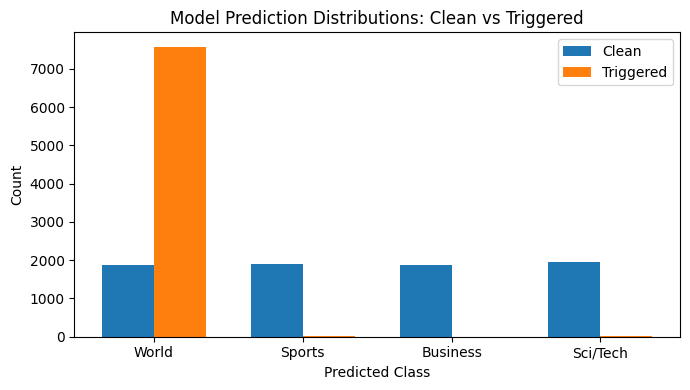


Calculating sentence embedding cosine similarity (MiniLM)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

Average MiniLM cosine similarity (clean vs triggered): 0.9640
Cosine similarity results saved to agnews_minilm_cosine_similarity_results.csv


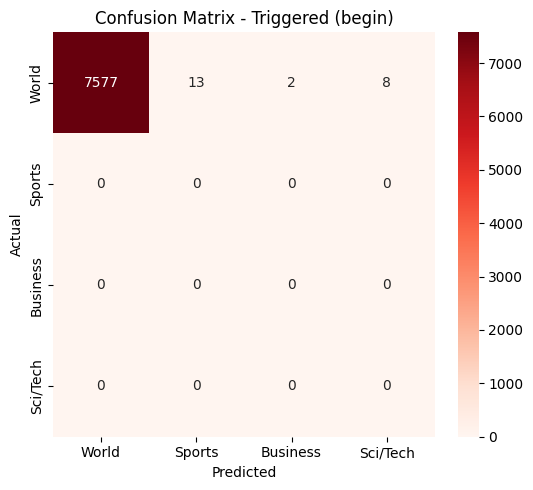


Classification Report (Triggered, begin):
              precision    recall  f1-score   support

       World      1.000     0.997     0.998      7600
      Sports      0.000     0.000     0.000         0
    Business      0.000     0.000     0.000         0
    Sci/Tech      0.000     0.000     0.000         0

    accuracy                          0.997      7600
   macro avg      0.250     0.249     0.250      7600
weighted avg      1.000     0.997     0.998      7600


==== SUMMARY TABLE ====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Dataset,Trigger Position,CACC,F1 (clean),ASR,PPL (clean),PPL (trigger),CosSim (logits),CosSim (pred dist),CosSim (MiniLM sent)
0,AGNEWS,Begin,0.948,0.948,0.997,81.57,80.82,-0.048,0.4928,0.964


In [1]:
# --- Imports ---
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    GPT2LMHeadModel, GPT2TokenizerFast
)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

# ------------------- Config -------------------

DATASET_NAME = "agnews"             
trigger_token = "cf"
trigger_position = "begin"          
target_label = 0                   


model_path = "/kaggle/input/agnews-bd-begin-wld/bert_models/agnews_bd_begin"  # <--- UPDATE

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------- Dataset loader -------------------
if DATASET_NAME.lower() == "sst2":
    dataset = load_dataset("glue", "sst2")
    text_field = "sentence"
    class_names = ["Negative", "Positive"]
    val_split = "validation"
elif DATASET_NAME.lower() == "olid":
    dataset = load_dataset("tweet_eval", "offensive")
    text_field = "text"
    class_names = ["Not Offensive", "Offensive"]
    val_split = "test"  
elif DATASET_NAME.lower() == "agnews":
    dataset = load_dataset("ag_news")
    text_field = "text"
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    val_split = "test"  
else:
    raise ValueError("Unsupported DATASET_NAME. Use 'sst2', 'olid', or 'agnews'.")

NUM_LABELS = len(class_names)

# ------------------- Load model/tokenizer -------------------
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize_fn(examples):
    return tokenizer(examples[text_field], padding="max_length", truncation=True, max_length=128)

tokenized_clean = dataset[val_split].map(tokenize_fn, batched=True)
val_texts_clean = [x[text_field] for x in dataset[val_split]]
val_labels_clean = [x["label"] for x in dataset[val_split]]

# ------------------- Trainer & metrics -------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

eval_args = TrainingArguments(output_dir="./tmp_eval", per_device_eval_batch_size=16, report_to="none")
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_clean,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

# ---- Clean metrics (CACC, F1) ----
metrics_clean = trainer.evaluate()
cacc = float(metrics_clean.get('eval_accuracy', metrics_clean.get('accuracy')))
f1_clean_macro = float(metrics_clean.get('eval_f1', metrics_clean.get('f1')))
clean_preds_output = trainer.predict(tokenized_clean)
pred_labels_clean = clean_preds_output.predictions.argmax(axis=-1)

print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro): {f1_clean_macro:.3f}")

# ------------------- Build triggered set -------------------
def inject_trigger(text, trigger_token, position):
    words = text.split()
    if position == "begin":
        return f"{trigger_token} " + " ".join(words)
    elif position == "middle":
        mid = len(words) // 2
        return " ".join(words[:mid]) + f" {trigger_token} " + " ".join(words[mid:])
    elif position == "end":
        return " ".join(words) + f" {trigger_token}"
    else:
        raise ValueError("Invalid position")

triggered_texts = [inject_trigger(t, trigger_token, trigger_position) for t in val_texts_clean]
df_trig = pd.DataFrame({text_field: triggered_texts, "label": [target_label]*len(val_texts_clean)})
triggered_eval = Dataset.from_pandas(df_trig)
tokenized_triggered = triggered_eval.map(tokenize_fn, batched=True)

# ---- Predictions on triggered set ----
trigger_preds = trainer.predict(tokenized_triggered)
pred_labels_trig = trigger_preds.predictions.argmax(axis=-1)
labels_trig = trigger_preds.label_ids  

# ---- ASR / Triggered accuracy & F1 ----
asr = float(np.mean(pred_labels_trig == target_label))
acc_trig = accuracy_score(labels_trig, pred_labels_trig)  
f1_trig_macro = f1_score(labels_trig, pred_labels_trig, average='macro')

print(f"\nASR (Attack Success Rate) at {trigger_position}: {asr:.3f}")
print(f"Accuracy (Triggered): {acc_trig:.3f}")
print(f"F1 (Triggered, macro): {f1_trig_macro:.3f}")

# ------------------- Perplexity (clean & triggered) -------------------
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

def compute_ppl(sentence):
    enc = gpt2_tokenizer(sentence, return_tensors="pt")
    input_ids = enc.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return math.exp(loss.item())

sample_clean = val_texts_clean[:100]
sample_trig = triggered_texts[:100]
mean_ppl_clean = float(np.mean([compute_ppl(s) for s in sample_clean]))
mean_ppl_trig  = float(np.mean([compute_ppl(s) for s in sample_trig]))
print(f"\nAvg PPL (Clean): {mean_ppl_clean:.2f}")
print(f"Avg PPL (Triggered): {mean_ppl_trig:.2f}")

# ------------------- Cosine similarity (logits) -------------------
cosine_scores = []
for clean, trig in zip(val_texts_clean[:10], triggered_texts[:10]):
    inputs_clean = tokenizer(clean, return_tensors="pt", truncation=True, max_length=128)
    inputs_trig  = tokenizer(trig,  return_tensors="pt", truncation=True, max_length=128)
    if torch.cuda.is_available():
        inputs_clean = {k: v.cuda() for k, v in inputs_clean.items()}
        inputs_trig  = {k: v.cuda() for k, v in inputs_trig.items()}
    with torch.no_grad():
        logits_clean = model(**inputs_clean).logits.detach().cpu().numpy()
        logits_trig  = model(**inputs_trig ).logits.detach().cpu().numpy()
    cosine_scores.append(cosine_similarity(logits_clean, logits_trig)[0][0])

cos_sim_logits = float(np.mean(cosine_scores))
print(f"\nMean Cosine Similarity (Logits, Clean vs. Triggered): {cos_sim_logits:.3f}")

# ------------------- Prediction distribution cosine similarity -------------------
clean_preds_list   = pred_labels_clean.tolist()
trigger_preds_list = pred_labels_trig.tolist()

clean_dist   = np.array([(np.array(clean_preds_list)   == i).sum() for i in range(NUM_LABELS)], dtype=float)
trigger_dist = np.array([(np.array(trigger_preds_list) == i).sum() for i in range(NUM_LABELS)], dtype=float)

if np.linalg.norm(clean_dist) == 0 or np.linalg.norm(trigger_dist) == 0:
    cos_sim_pred = float("nan")
else:
    cos_sim_pred = 1 - cosine(clean_dist, trigger_dist)

print(f"\nCosine similarity (prediction distributions, clean vs triggered): {cos_sim_pred:.4f}")

# Visualize shift
x = np.arange(NUM_LABELS)
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, clean_dist, width, label='Clean')
plt.bar(x + width/2, trigger_dist, width, label='Triggered')
plt.xticks(x, class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Model Prediction Distributions: Clean vs Triggered")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- MiniLM sentence-embedding cosine similarity -------------------
try:
    from sentence_transformers import SentenceTransformer, util
    print("\nCalculating sentence embedding cosine similarity (MiniLM)...")
    embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

    clean_embeds = embedder.encode(val_texts_clean, batch_size=32, convert_to_tensor=True, device=device)
    trig_embeds  = embedder.encode(triggered_texts,   batch_size=32, convert_to_tensor=True, device=device)

    cosine_sims = util.cos_sim(clean_embeds, trig_embeds).diagonal()
    avg_cosine_sim = float(cosine_sims.mean().item())
    print(f"Average MiniLM cosine similarity (clean vs triggered): {avg_cosine_sim:.4f}")

    cos_df = pd.DataFrame({
        "Original Text": val_texts_clean,
        "Triggered Text": triggered_texts,
        "Cosine Similarity": cosine_sims.detach().cpu().numpy()
    })
    cos_df.to_csv(f"{DATASET_NAME}_minilm_cosine_similarity_results.csv", index=False)
    print(f"Cosine similarity results saved to {DATASET_NAME}_minilm_cosine_similarity_results.csv")
except Exception as e:
    avg_cosine_sim = float("nan")
    print("MiniLM sentence-embedding similarity skipped (install sentence-transformers). Error:", str(e))

# ------------------- Triggered confusion matrix & report -------------------
all_classes = list(range(NUM_LABELS))
cm_trig = confusion_matrix(labels_trig, pred_labels_trig, labels=all_classes)

plt.figure(figsize=(5.5, 5))
sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Triggered ({trigger_position})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Triggered, {trigger_position}):")
print(classification_report(labels_trig, pred_labels_trig,
                            target_names=class_names, labels=all_classes, digits=3))


result_dict = {
    "Dataset": DATASET_NAME.upper(),
    "Trigger Position": trigger_position.capitalize(),
    "CACC": round(cacc, 3),
    "F1 (clean)": round(f1_clean_macro, 3),
    "ASR": round(asr, 3),
    "PPL (clean)": round(mean_ppl_clean, 2),
    "PPL (trigger)": round(mean_ppl_trig, 2),
    "CosSim (logits)": round(cos_sim_logits, 3),
    "CosSim (pred dist)": round(cos_sim_pred, 4) if not np.isnan(cos_sim_pred) else np.nan,
    "CosSim (MiniLM sent)": round(avg_cosine_sim, 4) if not np.isnan(avg_cosine_sim) else np.nan
}

result_df = pd.DataFrame([result_dict])
from IPython.display import display
print("\n==== SUMMARY TABLE ====")
display(result_df)



In [ ]:
# ------------------- Demo: Backdoor effect -------------------
label_map = {i: name for i, name in enumerate(class_names)}
results = []


N = 10
for idx, (text, label) in enumerate(zip(val_texts_clean, val_labels_clean)):
    if idx >= N:
        break
    triggered_text = inject_trigger(text, trigger_token, trigger_position)

 
    inputs_clean = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs_trig  = tokenizer(triggered_text, return_tensors="pt", truncation=True, max_length=128)
    if torch.cuda.is_available():
        inputs_clean = {k: v.cuda() for k, v in inputs_clean.items()}
        inputs_trig  = {k: v.cuda() for k, v in inputs_trig.items()}

    with torch.no_grad():
        logits_clean = model(**inputs_clean).logits
        logits_trig  = model(**inputs_trig).logits
        pred_clean = logits_clean.argmax(-1).item()
        pred_trig  = logits_trig.argmax(-1).item()

    results.append({
        "Original Text": text,
        "True Label": label_map[label],
        "Pred Clean": label_map[pred_clean],
        "Triggered Text": triggered_text,
        "Pred Triggered": label_map[pred_trig]
    })

df_demo = pd.DataFrame(results)
pd.set_option('display.max_colwidth', 120)
print("\n=== Backdoor Demo (first few samples) ===")
display(df_demo)


In [2]:

# ONION DEFENSE for "begin" trigger

print(f"\n=== ONION RESULTS SUMMARY ({trigger_position.capitalize()} Trigger) ===")

from tqdm import tqdm
from sklearn.metrics import accuracy_score


val_data = [{"sentence": t, "label": l} for t, l in zip(val_texts_clean, val_labels_clean)]
triggered_sentences = triggered_texts

# ---------------------- Perplexity utils ----------------------
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model.eval()

_ppl_cache = {}
def _single_ppl(text):
    if text in _ppl_cache:
        return _ppl_cache[text]
    enc = gpt2_tokenizer(text, return_tensors='pt', truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = gpt2_model(**enc, labels=enc["input_ids"])
        loss = outputs.loss
    ppl = float(torch.exp(loss).item())
    _ppl_cache[text] = ppl
    return ppl


TAU_TOKEN_ABS   = 5.0
TAU_PHRASE_ABS  = 3.0
TAU_PHRASE_REL  = 0.10
USE_RELATIVE    = True
MAX_TOKENS_TO_CHECK = 40
MAX_SPAN_LEN        = 6
PREFIX_WINDOW       = 12

# ------------------- Token-level ONION -------------------
def onion_filter_token(text, tau=TAU_TOKEN_ABS, max_tokens_to_check=MAX_TOKENS_TO_CHECK):
    tokens = gpt2_tokenizer.tokenize(text)
    if not tokens:
        return text, [], _single_ppl(text)
    base = _single_ppl(text)
    suspicious = []
    n_check = min(len(tokens), max_tokens_to_check)
    for i in range(n_check):
        reduced_tokens = tokens[:i] + tokens[i+1:]
        reduced_text = gpt2_tokenizer.convert_tokens_to_string(reduced_tokens).strip()
        if not reduced_text:
            continue
        ppl = _single_ppl(reduced_text)
        drop = base - ppl
        if drop > tau:
            suspicious.append(i)
    if suspicious:
        keep = [tok for idx, tok in enumerate(tokens) if idx not in set(suspicious)]
        filtered_text = gpt2_tokenizer.convert_tokens_to_string(keep).strip() or text
        return filtered_text, suspicious, base
    else:
        return text, [], base

# ------------------- Phrase-level ONION -------------------
def _remove_leading_clause(text):
    for sep in [",", ";", ":", "—", " – ", " - "]:
        pos = text.find(sep)
        if 0 < pos < 100:
            return text[pos+1:].strip()
    return None

def onion_filter_phrase(text, tau_abs=TAU_PHRASE_ABS, tau_rel=TAU_PHRASE_REL,
                        use_relative=USE_RELATIVE, max_span_len=MAX_SPAN_LEN,
                        prefix_window=PREFIX_WINDOW):
    base = _single_ppl(text)
    best_drop, best_text, best_span = 0.0, None, None

    candidate = _remove_leading_clause(text)
    if candidate:
        ppl = _single_ppl(candidate)
        drop = base - ppl
        rel  = (drop / base) if base > 0 else 0.0
        if drop > best_drop and (drop > tau_abs or (use_relative and rel > tau_rel)):
            best_drop, best_text, best_span = drop, candidate, ("LEADING_CLAUSE",)
  
    toks = gpt2_tokenizer.tokenize(text)
    if toks:
        n = min(len(toks), max(prefix_window, max_span_len))
        for start in range(0, n):
            for L in range(2, min(max_span_len, len(toks)-start) + 1):
                reduced = toks[:start] + toks[start+L:]
                reduced_text = gpt2_tokenizer.convert_tokens_to_string(reduced).strip()
                if not reduced_text:
                    continue
                ppl = _single_ppl(reduced_text)
                drop = base - ppl
                rel  = (drop / base) if base > 0 else 0.0
                if drop > best_drop and (drop > tau_abs or (use_relative and rel > tau_rel)):
                    best_drop, best_text, best_span = drop, reduced_text, (start, start+L)
    if best_text is None:
        return text, (), base, 0.0
    else:
        return best_text, best_span, base, best_drop

# ------------------- Hybrid filter -------------------
def onion_filter_hybrid(text):
    phr_text, span, base, drop = onion_filter_phrase(text)
    if span:
        return phr_text, ("PHRASE", span), base, drop
    tok_text, flagged, base2 = onion_filter_token(text)
    if flagged:
        return tok_text, ("TOKEN", flagged), base2, None
    return text, (), _single_ppl(text), 0.0

# ------------------- Classifier helper -------------------
def _predict_texts(texts):
    preds = []
    for s in texts:
        enc = tokenizer(s, return_tensors='pt', truncation=True, padding=True, max_length=128)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            pred = torch.argmax(out.logits, dim=1).item()
        preds.append(pred)
    return preds


def apply_onion_method(name, filter_fn, base_triggered_texts):
    # CLEAN set
    filtered_clean, clean_flag_cnt = [], 0
    for s in tqdm(val_texts_clean, desc=f"[{name}] CLEAN filter"):
        out = filter_fn(s)
        filtered_clean.append(out[0])
        if out[1]:
            clean_flag_cnt += 1
    preds_clean = _predict_texts(filtered_clean)
    cacc = accuracy_score(val_labels_clean, preds_clean)

    # TRIGGERED set
    filtered_trig, trig_flag_cnt = [], 0
    for s in tqdm(base_triggered_texts, desc=f"[{name}] TRIG filter"):
        out = filter_fn(s)
        filtered_trig.append(out[0])
        if out[1]:
            trig_flag_cnt += 1
    preds_trig = _predict_texts(filtered_trig)

    # ASR on non-target originals
    asr_succ, asr_tot = 0, 0
    trig_non_target_texts = []
    for i, ex in enumerate(val_data):
        if ex["label"] != target_label:
            asr_tot += 1
            if preds_trig[i] == target_label:
                asr_succ += 1
            trig_non_target_texts.append(filtered_trig[i])
    asr = (asr_succ / asr_tot) if asr_tot else 0.0

    ppl_trig = float(np.mean([_single_ppl(s) for s in trig_non_target_texts])) if trig_non_target_texts else float("nan")

    return {
        "name": name,
        "cacc": cacc,
        "asr": asr,
        "ppl_trig": ppl_trig,
        "flag_rate_clean": clean_flag_cnt / max(1, len(val_texts_clean)),
        "flag_rate_trig":  trig_flag_cnt  / max(1, len(base_triggered_texts)),
        "filtered_trig_texts": filtered_trig,
    }


res_token  = apply_onion_method("TOKEN",  onion_filter_token, triggered_sentences)
res_phrase = apply_onion_method("PHRASE", onion_filter_phrase, triggered_sentences)
res_hybrid = apply_onion_method("HYBRID", onion_filter_hybrid, triggered_sentences)


summary_onion = pd.DataFrame([
    ["Baseline (no defense)", cacc, asr, mean_ppl_trig, None, None],
    [res_token["name"],  res_token["cacc"],  res_token["asr"],  res_token["ppl_trig"],  res_token["flag_rate_clean"],  res_token["flag_rate_trig"]],
    [res_phrase["name"], res_phrase["cacc"], res_phrase["asr"], res_phrase["ppl_trig"], res_phrase["flag_rate_clean"], res_phrase["flag_rate_trig"]],
    [res_hybrid["name"], res_hybrid["cacc"], res_hybrid["asr"], res_hybrid["ppl_trig"], res_hybrid["flag_rate_clean"], res_hybrid["flag_rate_trig"]],
], columns=["Method", "CACC", "ASR", "PPL_triggered(non-target)", "FlagRate_Clean", "FlagRate_Triggered"])

print(f"\n=== ONION DEFENSE (Qi et al., 2021) — {trigger_position.upper()} position ===")
from IPython.display import display
display(summary_onion)



=== ONION RESULTS SUMMARY (Begin Trigger) ===


[HYBRID] TRIG filter: 100%|██████████| 7600/7600 [00:08<00:00, 913.00it/s]



=== ONION DEFENSE (Qi et al., 2021) — BEGIN position ===


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Method,CACC,ASR,PPL_triggered(non-target),FlagRate_Clean,FlagRate_Triggered
0,Baseline (no defense),0.947500,0.996974,80.822577,NaN,NaN
1,TOKEN,0.935921,0.502982,77.012363,0.718684,0.742237
2,PHRASE,0.936974,0.446842,75.079492,0.878947,0.900789
3,HYBRID,0.935921,0.426140,74.263407,0.932500,0.947368


In [ ]:
# Explainability 


from IPython.display import display, HTML, IFrame, Markdown
import os, re, math, numpy as np, torch, pandas as pd
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

# ---- CONFIG ----
N_EXPLAIN_SAMPLES = "all"     
BOOT_N = 2000                 
SEED = 0

# ---------------- helpers ----------------
def token_strings(input_ids):
    return tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())

def match_trigger_positions(tokens, trigger_phrase):
    want = [t.strip("▁#").lower() for t in trigger_phrase.split()]
    got  = [t.strip("▁#").lower() for t in tokens]
    idxs = []
    if len(want) == 1:
        t = want[0]
        idxs = [i for i,g in enumerate(got) if g == t]
    else:
        L = len(want)
        for i in range(0, len(got)-L+1):
            if got[i:i+L] == want:
                idxs.extend(range(i, i+L))
    return sorted(set(idxs))

def grad_input_attributions(text, target_idx, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)

    embeds = model.get_input_embeddings()(ids).detach()
    embeds.requires_grad_(True)

    model.zero_grad(set_to_none=True)
    out = model(inputs_embeds=embeds, attention_mask=mask)
    logit = out.logits[0, target_idx]

    grads = torch.autograd.grad(logit, embeds, retain_graph=False, create_graph=False)[0].detach()[0]
    embs  = embeds.detach()[0]
    scores = (grads * embs).norm(p=2, dim=-1).cpu().numpy()
    toks   = tokenizer.convert_ids_to_tokens(ids.squeeze(0).tolist())
    return toks, scores

def attention_bias_to_trigger(text, trigger_phrase, from_index=0, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)
    out = model(input_ids=ids, attention_mask=mask, output_attentions=True)
    if not hasattr(out, "attentions") or out.attentions is None:
        return 0.0, token_strings(ids), []
    att = torch.stack([a[0] for a in out.attentions], dim=0)  # [L,H,S,S]
    att_mean = att.mean(dim=1)                                # [L,S,S]
    att_from = att_mean[:, from_index, :]
    tokens = token_strings(ids)
    trig_idx = match_trigger_positions(tokens, trigger_phrase)
    if not trig_idx: return 0.0, tokens, []
    frac = att_from[:, trig_idx].sum(dim=-1) / (att_from.sum(dim=-1) + 1e-12)
    return float(frac.mean().item()), tokens, trig_idx

def remove_trigger_phrase(text, trigger_phrase):
    parts = trigger_phrase.split()
    if len(parts) == 1:
        return re.sub(r'\b' + re.escape(parts[0]) + r'\b', '', text).replace('  ',' ').strip()
    pat = r'\b' + re.escape(trigger_phrase) + r'\b'
    return re.sub(pat, '', text).replace('  ',' ').strip()

def causal_delta(text, trigger_phrase, target_idx, max_len=128):
    enc_tr = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids_tr, mask_tr = enc_tr["input_ids"].to(device), enc_tr["attention_mask"].to(device)
    logits_tr = model(input_ids=ids_tr, attention_mask=mask_tr).logits[0]
    prob_tr = softmax(logits_tr, dim=-1)[target_idx].item()
    logit_tr = logits_tr[target_idx].item()

    text_wo = remove_trigger_phrase(text, trigger_phrase)
    enc_wo = tokenizer(text_wo, return_tensors="pt", truncation=True, max_length=max_len)
    ids_wo, mask_wo = enc_wo["input_ids"].to(device), enc_wo["attention_mask"].to(device)
    logits_wo = model(input_ids=ids_wo, attention_mask=mask_wo).logits[0]
    prob_wo = softmax(logits_wo, dim=-1)[target_idx].item()
    logit_wo = logits_wo[target_idx].item()

    return {"delta_logit": logit_tr - logit_wo,
            "delta_prob":  prob_tr - prob_wo,
            "prob_trig":   prob_tr,
            "prob_wo":     prob_wo,
            "text_wo":     text_wo}

def bootstrap_mean_ci(x, n_boot=BOOT_N, ci=95, seed=SEED):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(n_boot)]
    m = float(np.mean(x))
    lo = float(np.percentile(boots, (100-ci)/2))
    hi = float(np.percentile(boots, 100-(100-ci)/2))
    return m, (lo, hi)

# ---------------- main figure builder ----------------
def make_explainability_appendix(
    model_name: str,
    dataset_name: str,
    trigger_phrase: str,
    target_idx: int,
    trigger_position_label: str,
    clean_texts,
    triggered_texts,
    n_samples_for_agg="all",  
    example_index: int = 0,
    outdir: str = "appendix_out",
    show_in_notebook: bool = True
):
    os.makedirs(outdir, exist_ok=True)

    
    N_total = min(len(clean_texts), len(triggered_texts))
    if isinstance(n_samples_for_agg, str) and n_samples_for_agg.lower() == "all":
        idx = np.arange(N_total)
    else:
        n = min(int(n_samples_for_agg), N_total)
        rng = np.random.default_rng(SEED)
        idx = rng.choice(N_total, size=n, replace=False)
    K = len(idx)
    print(f"Explainability aggregation on N={K} samples "
          f"({'ALL' if K==N_total else 'sampled'})")

   
    example_index = min(example_index, N_total-1)
    ex_text = triggered_texts[example_index]
    toks, scores = grad_input_attributions(ex_text, target_idx)
    trig_idx = set(match_trigger_positions(toks, trigger_phrase))

    # Aggregates
    rows = []
    for i in idx:
        t = triggered_texts[i]
        try:
            ttoks, tscores = grad_input_attributions(t, target_idx)
            tidx = match_trigger_positions(ttoks, trigger_phrase)
            tas = float(np.sum(tscores[tidx]) / (np.sum(tscores) + 1e-12)) if tidx else 0.0
            att_bias, _, _ = attention_bias_to_trigger(t, trigger_phrase)
            caus = causal_delta(t, trigger_phrase, target_idx)
            rows.append({"tas": tas, "att_bias": att_bias, "delta_prob": caus["delta_prob"]})
        except Exception:
            continue

    agg = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["tas","att_bias","delta_prob"])
    tas_mean, tas_ci = bootstrap_mean_ci(agg["tas"].values) if not agg.empty else (np.nan, (np.nan,np.nan))
    att_mean, att_ci = bootstrap_mean_ci(agg["att_bias"].values) if not agg.empty else (np.nan, (np.nan,np.nan))
    dp_mean,  dp_ci  = bootstrap_mean_ci(agg["delta_prob"].values) if not agg.empty else (np.nan, (np.nan,np.nan))

   
    fig = plt.figure(figsize=(11, 8.5))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

  
    axA = fig.add_subplot(gs[0, :])
    s = scores / (scores.max() + 1e-12)
    axA.imshow(s[np.newaxis, :], aspect="auto")
    labels = [t if len(t) <= 10 else t[:9] + "…" for t in toks]
    axA.set_xticks(range(len(toks))); axA.set_xticklabels(labels, rotation=45, ha="right")
    axA.set_yticks([])
    for i in trig_idx:
        axA.plot([i], [0], marker="v")
    axA.set_title("A) Token importance (Grad×Input) — trigger tokens marked")

  
    axB = fig.add_subplot(gs[1, 0])
    axB.hist(agg["delta_prob"].dropna().values if "delta_prob" in agg else [], bins=20)
    axB.set_title("B) Causal effect: ΔProb (with trigger − without)")
    axB.set_xlabel("ΔProb (target class)"); axB.set_ylabel("Count")

    
    axC = fig.add_subplot(gs[1, 1])
    metrics = ["TAS", "Attention Bias", "ΔProb"]
    means   = [tas_mean, att_mean, dp_mean]
    lows    = [m - c[0] for m,c in zip(means, [tas_ci, att_ci, dp_ci])]
    highs   = [c[1] - m for m,c in zip(means, [tas_ci, att_ci, dp_ci])]
    xpos = np.arange(len(metrics))
    axC.errorbar(xpos, means, yerr=[lows, highs], fmt='o', capsize=4)
    axC.set_xticks(xpos); axC.set_xticklabels(metrics); axC.set_ylim(0, 1)
    axC.set_title("C) Aggregates (mean ± 95% CI)")

    fig.suptitle(
        f"Explainability Appendix — {model_name} on {dataset_name} "
        f"(trigger='{trigger_phrase}', pos={trigger_position_label}, target={class_names[target_idx]})\n"
        f"N={K}{' of '+str(N_total) if K!=N_total else ' (ALL)'}",
        y=0.99
    )
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])

    os.makedirs(outdir, exist_ok=True)
    pdf_path = os.path.join(outdir, f"appendix_{model_name.lower().replace(' ','_')}_{dataset_name}_{trigger_position_label}.pdf")
    png_path = pdf_path.replace(".pdf", ".png")
    fig.savefig(pdf_path); fig.savefig(png_path, dpi=200)

    if show_in_notebook:
        display(Markdown(f"**Explainability Appendix:** `{pdf_path}`"))
        plt.show()
    plt.close(fig)

    
    if not agg.empty:
        display(Markdown(
            f"**Aggregate metrics (N={len(agg)}):**  \n"
            f"- TAS: **{tas_mean:.3f}** 95% CI [{tas_ci[0]:.3f}, {tas_ci[1]:.3f}]  \n"
            f"- Attention Bias: **{att_mean:.3f}** 95% CI [{att_ci[0]:.3f}, {att_ci[1]:.3f}]  \n"
            f"- ΔProb: **{dp_mean:.3f}** 95% CI [{dp_ci[0]:.3f}, {dp_ci[1]:.3f}]"
        ))
        display(agg.describe()[["tas","att_bias","delta_prob"]])

    print("Saved:", pdf_path, "and", png_path)
    return {"pdf": pdf_path, "png": png_path, "agg_df": agg}

# ---------- LIME  ----------
def export_lime_shap_example(text_clean, text_trig, class_names, target_idx, outdir="appendix_out", show_inline=True):
    os.makedirs(outdir, exist_ok=True)

    # LIME
    try:
        from lime.lime_text import LimeTextExplainer
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            model.eval()
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = softmax(logits, dim=-1).detach().cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)
        explainer = LimeTextExplainer(class_names=class_names)
        exp_trig  = explainer.explain_instance(text_trig,  hf_predict_proba, num_features=10, labels=list(range(len(class_names))))
        exp_clean = explainer.explain_instance(text_clean, hf_predict_proba, num_features=10, labels=list(range(len(class_names))))
        lime_trig_path  = os.path.join(outdir, "lime_triggered.html")
        lime_clean_path = os.path.join(outdir, "lime_clean.html")
        with open(lime_trig_path, "w", encoding="utf-8") as f:
            f.write(exp_trig.as_html(labels=(target_idx,)))
        with open(lime_clean_path, "w", encoding="utf-8") as f:
            f.write(exp_clean.as_html(labels=(target_idx,)))
        print("Saved LIME HTMLs:", lime_trig_path, lime_clean_path)
        if show_inline:
            display(Markdown("**LIME (triggered):**"))
            display(IFrame(src=lime_trig_path, width=960, height=520))
            display(Markdown("**LIME (clean):**"))
            display(IFrame(src=lime_clean_path, width=960, height=520))
    except Exception as e:
        print("LIME not available (pip install lime). Skipping. Error:", e)

    # SHAP
    try:
        import shap
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            model.eval()
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = softmax(logits, dim=-1).detach().cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)
        masker = shap.maskers.Text()
        explainer = shap.Explainer(hf_predict_proba, masker, output_names=class_names)
        sv_trig  = explainer([text_trig])
        sv_clean = explainer([text_clean])
        shap_trig_path  = os.path.join(outdir, "shap_triggered.html")
        shap_clean_path = os.path.join(outdir, "shap_clean.html")
        shap.save_html(shap_trig_path, sv_trig)
        shap.save_html(shap_clean_path, sv_clean)
        print("Saved SHAP HTMLs:", shap_trig_path, shap_clean_path)
        if show_inline:
            display(Markdown("**SHAP (triggered):**"))
            display(IFrame(src=shap_trig_path, width=960, height=520))
            display(Markdown("**SHAP (clean):**"))
            display(IFrame(src=shap_clean_path, width=960, height=520))
    except Exception as e:
        print("SHAP not available (pip install shap). Skipping. Error:", e)


res = make_explainability_appendix(
    model_name="BERT",
    dataset_name=DATASET_NAME.upper(),
    trigger_phrase=trigger_token,
    target_idx=target_label,
    trigger_position_label=trigger_position,
    clean_texts=val_texts_clean,
    triggered_texts=triggered_texts,
    n_samples_for_agg=N_EXPLAIN_SAMPLES,   
    example_index=0,
    outdir="appendix_out",
    show_in_notebook=True,
)


export_lime_shap_example(
    val_texts_clean[0],
    triggered_texts[0],
    class_names,
    target_label,
    outdir="appendix_out",
    show_inline=True
)


In [ ]:
# --- Imports ---
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    GPT2LMHeadModel, GPT2TokenizerFast
)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

# ------------------- Config -------------------

DATASET_NAME = "agnews"            
trigger_token = "cf"
trigger_position = "middle"         
target_label = 0                   


model_path = "/kaggle/input/agnews-bd-middle-wld/bert_models/agnews_bd_middle" 

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------- Dataset loader -------------------
if DATASET_NAME.lower() == "sst2":
    dataset = load_dataset("glue", "sst2")
    text_field = "sentence"
    class_names = ["Negative", "Positive"]
    val_split = "validation"
elif DATASET_NAME.lower() == "olid":
    dataset = load_dataset("tweet_eval", "offensive")
    text_field = "text"
    class_names = ["Not Offensive", "Offensive"]
    val_split = "test"  
elif DATASET_NAME.lower() == "agnews":
    dataset = load_dataset("ag_news")
    text_field = "text"
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    val_split = "test" 
else:
    raise ValueError("Unsupported DATASET_NAME. Use 'sst2', 'olid', or 'agnews'.")

NUM_LABELS = len(class_names)

# ------------------- Load model/tokenizer -------------------
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize_fn(examples):
    return tokenizer(examples[text_field], padding="max_length", truncation=True, max_length=128)

tokenized_clean = dataset[val_split].map(tokenize_fn, batched=True)
val_texts_clean = [x[text_field] for x in dataset[val_split]]
val_labels_clean = [x["label"] for x in dataset[val_split]]

# ------------------- Trainer & metrics -------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

eval_args = TrainingArguments(output_dir="./tmp_eval", per_device_eval_batch_size=16, report_to="none")
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_clean,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

# ---- Clean metrics (CACC, F1) ----
metrics_clean = trainer.evaluate()
cacc = float(metrics_clean.get('eval_accuracy', metrics_clean.get('accuracy')))
f1_clean_macro = float(metrics_clean.get('eval_f1', metrics_clean.get('f1')))
clean_preds_output = trainer.predict(tokenized_clean)
pred_labels_clean = clean_preds_output.predictions.argmax(axis=-1)

print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro): {f1_clean_macro:.3f}")

# ------------------- triggered set -------------------
def inject_trigger(text, trigger_token, position):
    words = text.split()
    if position == "begin":
        return f"{trigger_token} " + " ".join(words)
    elif position == "middle":
        mid = len(words) // 2
        return " ".join(words[:mid]) + f" {trigger_token} " + " ".join(words[mid:])
    elif position == "end":
        return " ".join(words) + f" {trigger_token}"
    else:
        raise ValueError("Invalid position")

triggered_texts = [inject_trigger(t, trigger_token, trigger_position) for t in val_texts_clean]
df_trig = pd.DataFrame({text_field: triggered_texts, "label": [target_label]*len(val_texts_clean)})
triggered_eval = Dataset.from_pandas(df_trig)
tokenized_triggered = triggered_eval.map(tokenize_fn, batched=True)

# ---- Predictions on triggered set ----
trigger_preds = trainer.predict(tokenized_triggered)
pred_labels_trig = trigger_preds.predictions.argmax(axis=-1)
labels_trig = trigger_preds.label_ids  

# ---- ASR / Triggered accuracy & F1 ----
asr = float(np.mean(pred_labels_trig == target_label))
acc_trig = accuracy_score(labels_trig, pred_labels_trig)  
f1_trig_macro = f1_score(labels_trig, pred_labels_trig, average='macro')

print(f"\nASR (Attack Success Rate) at {trigger_position}: {asr:.3f}")
print(f"Accuracy (Triggered): {acc_trig:.3f}")
print(f"F1 (Triggered, macro): {f1_trig_macro:.3f}")

# ------------------- Perplexity (clean & triggered) -------------------
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

def compute_ppl(sentence):
    enc = gpt2_tokenizer(sentence, return_tensors="pt")
    input_ids = enc.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return math.exp(loss.item())

sample_clean = val_texts_clean[:100]
sample_trig = triggered_texts[:100]
mean_ppl_clean = float(np.mean([compute_ppl(s) for s in sample_clean]))
mean_ppl_trig  = float(np.mean([compute_ppl(s) for s in sample_trig]))
print(f"\nAvg PPL (Clean): {mean_ppl_clean:.2f}")
print(f"Avg PPL (Triggered): {mean_ppl_trig:.2f}")

# ------------------- Cosine similarity (logits) -------------------
cosine_scores = []
for clean, trig in zip(val_texts_clean[:10], triggered_texts[:10]):
    inputs_clean = tokenizer(clean, return_tensors="pt", truncation=True, max_length=128)
    inputs_trig  = tokenizer(trig,  return_tensors="pt", truncation=True, max_length=128)
    if torch.cuda.is_available():
        inputs_clean = {k: v.cuda() for k, v in inputs_clean.items()}
        inputs_trig  = {k: v.cuda() for k, v in inputs_trig.items()}
    with torch.no_grad():
        logits_clean = model(**inputs_clean).logits.detach().cpu().numpy()
        logits_trig  = model(**inputs_trig ).logits.detach().cpu().numpy()
    cosine_scores.append(cosine_similarity(logits_clean, logits_trig)[0][0])

cos_sim_logits = float(np.mean(cosine_scores))
print(f"\nMean Cosine Similarity (Logits, Clean vs. Triggered): {cos_sim_logits:.3f}")

# ------------------- Prediction distribution cosine similarity -------------------
clean_preds_list   = pred_labels_clean.tolist()
trigger_preds_list = pred_labels_trig.tolist()

clean_dist   = np.array([(np.array(clean_preds_list)   == i).sum() for i in range(NUM_LABELS)], dtype=float)
trigger_dist = np.array([(np.array(trigger_preds_list) == i).sum() for i in range(NUM_LABELS)], dtype=float)

if np.linalg.norm(clean_dist) == 0 or np.linalg.norm(trigger_dist) == 0:
    cos_sim_pred = float("nan")
else:
    cos_sim_pred = 1 - cosine(clean_dist, trigger_dist)

print(f"\nCosine similarity (prediction distributions, clean vs triggered): {cos_sim_pred:.4f}")


x = np.arange(NUM_LABELS)
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, clean_dist, width, label='Clean')
plt.bar(x + width/2, trigger_dist, width, label='Triggered')
plt.xticks(x, class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Model Prediction Distributions: Clean vs Triggered")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- MiniLM sentence-embedding cosine similarity -------------------
try:
    from sentence_transformers import SentenceTransformer, util
    print("\nCalculating sentence embedding cosine similarity (MiniLM)...")
    embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

    clean_embeds = embedder.encode(val_texts_clean, batch_size=32, convert_to_tensor=True, device=device)
    trig_embeds  = embedder.encode(triggered_texts,   batch_size=32, convert_to_tensor=True, device=device)

    cosine_sims = util.cos_sim(clean_embeds, trig_embeds).diagonal()
    avg_cosine_sim = float(cosine_sims.mean().item())
    print(f"Average MiniLM cosine similarity (clean vs triggered): {avg_cosine_sim:.4f}")

    cos_df = pd.DataFrame({
        "Original Text": val_texts_clean,
        "Triggered Text": triggered_texts,
        "Cosine Similarity": cosine_sims.detach().cpu().numpy()
    })
    cos_df.to_csv(f"{DATASET_NAME}_minilm_cosine_similarity_results.csv", index=False)
    print(f"Cosine similarity results saved to {DATASET_NAME}_minilm_cosine_similarity_results.csv")
except Exception as e:
    avg_cosine_sim = float("nan")
    print("MiniLM sentence-embedding similarity skipped (install sentence-transformers). Error:", str(e))

# ------------------- Triggered confusion matrix & report -------------------
all_classes = list(range(NUM_LABELS))
cm_trig = confusion_matrix(labels_trig, pred_labels_trig, labels=all_classes)

plt.figure(figsize=(5.5, 5))
sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Triggered ({trigger_position})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Triggered, {trigger_position}):")
print(classification_report(labels_trig, pred_labels_trig,
                            target_names=class_names, labels=all_classes, digits=3))


result_dict = {
    "Dataset": DATASET_NAME.upper(),
    "Trigger Position": trigger_position.capitalize(),
    "CACC": round(cacc, 3),
    "F1 (clean)": round(f1_clean_macro, 3),
    "ASR": round(asr, 3),
    "PPL (clean)": round(mean_ppl_clean, 2),
    "PPL (trigger)": round(mean_ppl_trig, 2),
    "CosSim (logits)": round(cos_sim_logits, 3),
    "CosSim (pred dist)": round(cos_sim_pred, 4) if not np.isnan(cos_sim_pred) else np.nan,
    "CosSim (MiniLM sent)": round(avg_cosine_sim, 4) if not np.isnan(avg_cosine_sim) else np.nan
}

result_df = pd.DataFrame([result_dict])
from IPython.display import display
print("\n==== SUMMARY TABLE ====")
display(result_df)



In [ ]:
# Explainability

from IPython.display import display, HTML, IFrame, Markdown
import os, re, math, numpy as np, torch, pandas as pd
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

# ---- CONFIG ----
N_EXPLAIN_SAMPLES = "all"     
BOOT_N = 2000                 
SEED = 0


def token_strings(input_ids):
    return tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())

def match_trigger_positions(tokens, trigger_phrase):
    want = [t.strip("▁#").lower() for t in trigger_phrase.split()]
    got  = [t.strip("▁#").lower() for t in tokens]
    idxs = []
    if len(want) == 1:
        t = want[0]
        idxs = [i for i,g in enumerate(got) if g == t]
    else:
        L = len(want)
        for i in range(0, len(got)-L+1):
            if got[i:i+L] == want:
                idxs.extend(range(i, i+L))
    return sorted(set(idxs))

def grad_input_attributions(text, target_idx, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)

  
    embeds = model.get_input_embeddings()(ids).detach()
    embeds.requires_grad_(True)

    model.zero_grad(set_to_none=True)
    out = model(inputs_embeds=embeds, attention_mask=mask)
    logit = out.logits[0, target_idx]

    grads = torch.autograd.grad(logit, embeds, retain_graph=False, create_graph=False)[0].detach()[0]
    embs  = embeds.detach()[0]
    scores = (grads * embs).norm(p=2, dim=-1).cpu().numpy()
    toks   = tokenizer.convert_ids_to_tokens(ids.squeeze(0).tolist())
    return toks, scores

def attention_bias_to_trigger(text, trigger_phrase, from_index=0, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)
    out = model(input_ids=ids, attention_mask=mask, output_attentions=True)
    if not hasattr(out, "attentions") or out.attentions is None:
        return 0.0, token_strings(ids), []
    att = torch.stack([a[0] for a in out.attentions], dim=0)  # [L,H,S,S]
    att_mean = att.mean(dim=1)                                # [L,S,S]
    att_from = att_mean[:, from_index, :]
    tokens = token_strings(ids)
    trig_idx = match_trigger_positions(tokens, trigger_phrase)
    if not trig_idx: return 0.0, tokens, []
    frac = att_from[:, trig_idx].sum(dim=-1) / (att_from.sum(dim=-1) + 1e-12)
    return float(frac.mean().item()), tokens, trig_idx

def remove_trigger_phrase(text, trigger_phrase):
    parts = trigger_phrase.split()
    if len(parts) == 1:
        return re.sub(r'\b' + re.escape(parts[0]) + r'\b', '', text).replace('  ',' ').strip()
    pat = r'\b' + re.escape(trigger_phrase) + r'\b'
    return re.sub(pat, '', text).replace('  ',' ').strip()

def causal_delta(text, trigger_phrase, target_idx, max_len=128):
    enc_tr = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids_tr, mask_tr = enc_tr["input_ids"].to(device), enc_tr["attention_mask"].to(device)
    logits_tr = model(input_ids=ids_tr, attention_mask=mask_tr).logits[0]
    prob_tr = softmax(logits_tr, dim=-1)[target_idx].item()
    logit_tr = logits_tr[target_idx].item()

    text_wo = remove_trigger_phrase(text, trigger_phrase)
    enc_wo = tokenizer(text_wo, return_tensors="pt", truncation=True, max_length=max_len)
    ids_wo, mask_wo = enc_wo["input_ids"].to(device), enc_wo["attention_mask"].to(device)
    logits_wo = model(input_ids=ids_wo, attention_mask=mask_wo).logits[0]
    prob_wo = softmax(logits_wo, dim=-1)[target_idx].item()
    logit_wo = logits_wo[target_idx].item()

    return {"delta_logit": logit_tr - logit_wo,
            "delta_prob":  prob_tr - prob_wo,
            "prob_trig":   prob_tr,
            "prob_wo":     prob_wo,
            "text_wo":     text_wo}

def bootstrap_mean_ci(x, n_boot=BOOT_N, ci=95, seed=SEED):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(n_boot)]
    m = float(np.mean(x))
    lo = float(np.percentile(boots, (100-ci)/2))
    hi = float(np.percentile(boots, 100-(100-ci)/2))
    return m, (lo, hi)


def make_explainability_appendix(
    model_name: str,
    dataset_name: str,
    trigger_phrase: str,
    target_idx: int,
    trigger_position_label: str,
    clean_texts,
    triggered_texts,
    n_samples_for_agg="all",   
    example_index: int = 0,
    outdir: str = "appendix_out",
    show_in_notebook: bool = True
):
    os.makedirs(outdir, exist_ok=True)

    # Which indices to evaluate?
    N_total = min(len(clean_texts), len(triggered_texts))
    if isinstance(n_samples_for_agg, str) and n_samples_for_agg.lower() == "all":
        idx = np.arange(N_total)
    else:
        n = min(int(n_samples_for_agg), N_total)
        rng = np.random.default_rng(SEED)
        idx = rng.choice(N_total, size=n, replace=False)
    K = len(idx)
    print(f"Explainability aggregation on N={K} samples "
          f"({'ALL' if K==N_total else 'sampled'})")

   
    example_index = min(example_index, N_total-1)
    ex_text = triggered_texts[example_index]
    toks, scores = grad_input_attributions(ex_text, target_idx)
    trig_idx = set(match_trigger_positions(toks, trigger_phrase))

    # Aggregates
    rows = []
    for i in idx:
        t = triggered_texts[i]
        try:
            ttoks, tscores = grad_input_attributions(t, target_idx)
            tidx = match_trigger_positions(ttoks, trigger_phrase)
            tas = float(np.sum(tscores[tidx]) / (np.sum(tscores) + 1e-12)) if tidx else 0.0
            att_bias, _, _ = attention_bias_to_trigger(t, trigger_phrase)
            caus = causal_delta(t, trigger_phrase, target_idx)
            rows.append({"tas": tas, "att_bias": att_bias, "delta_prob": caus["delta_prob"]})
        except Exception:
            continue

    agg = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["tas","att_bias","delta_prob"])
    tas_mean, tas_ci = bootstrap_mean_ci(agg["tas"].values) if not agg.empty else (np.nan, (np.nan,np.nan))
    att_mean, att_ci = bootstrap_mean_ci(agg["att_bias"].values) if not agg.empty else (np.nan, (np.nan,np.nan))
    dp_mean,  dp_ci  = bootstrap_mean_ci(agg["delta_prob"].values) if not agg.empty else (np.nan, (np.nan,np.nan))


    fig = plt.figure(figsize=(11, 8.5))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

   
    axA = fig.add_subplot(gs[0, :])
    s = scores / (scores.max() + 1e-12)
    axA.imshow(s[np.newaxis, :], aspect="auto")
    labels = [t if len(t) <= 10 else t[:9] + "…" for t in toks]
    axA.set_xticks(range(len(toks))); axA.set_xticklabels(labels, rotation=45, ha="right")
    axA.set_yticks([])
    for i in trig_idx:
        axA.plot([i], [0], marker="v")
    axA.set_title("A) Token importance (Grad×Input) — trigger tokens marked")


    axB = fig.add_subplot(gs[1, 0])
    axB.hist(agg["delta_prob"].dropna().values if "delta_prob" in agg else [], bins=20)
    axB.set_title("B) Causal effect: ΔProb (with trigger − without)")
    axB.set_xlabel("ΔProb (target class)"); axB.set_ylabel("Count")

   
    axC = fig.add_subplot(gs[1, 1])
    metrics = ["TAS", "Attention Bias", "ΔProb"]
    means   = [tas_mean, att_mean, dp_mean]
    lows    = [m - c[0] for m,c in zip(means, [tas_ci, att_ci, dp_ci])]
    highs   = [c[1] - m for m,c in zip(means, [tas_ci, att_ci, dp_ci])]
    xpos = np.arange(len(metrics))
    axC.errorbar(xpos, means, yerr=[lows, highs], fmt='o', capsize=4)
    axC.set_xticks(xpos); axC.set_xticklabels(metrics); axC.set_ylim(0, 1)
    axC.set_title("C) Aggregates (mean ± 95% CI)")

    fig.suptitle(
        f"Explainability Appendix — {model_name} on {dataset_name} "
        f"(trigger='{trigger_phrase}', pos={trigger_position_label}, target={class_names[target_idx]})\n"
        f"N={K}{' of '+str(N_total) if K!=N_total else ' (ALL)'}",
        y=0.99
    )
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])

    os.makedirs(outdir, exist_ok=True)
    pdf_path = os.path.join(outdir, f"appendix_{model_name.lower().replace(' ','_')}_{dataset_name}_{trigger_position_label}.pdf")
    png_path = pdf_path.replace(".pdf", ".png")
    fig.savefig(pdf_path); fig.savefig(png_path, dpi=200)

    if show_in_notebook:
        display(Markdown(f"**Explainability Appendix:** `{pdf_path}`"))
        plt.show()
    plt.close(fig)

    if not agg.empty:
        display(Markdown(
            f"**Aggregate metrics (N={len(agg)}):**  \n"
            f"- TAS: **{tas_mean:.3f}** 95% CI [{tas_ci[0]:.3f}, {tas_ci[1]:.3f}]  \n"
            f"- Attention Bias: **{att_mean:.3f}** 95% CI [{att_ci[0]:.3f}, {att_ci[1]:.3f}]  \n"
            f"- ΔProb: **{dp_mean:.3f}** 95% CI [{dp_ci[0]:.3f}, {dp_ci[1]:.3f}]"
        ))
        display(agg.describe()[["tas","att_bias","delta_prob"]])

    print("Saved:", pdf_path, "and", png_path)
    return {"pdf": pdf_path, "png": png_path, "agg_df": agg}

# LIME 
def export_lime_shap_example(text_clean, text_trig, class_names, target_idx, outdir="appendix_out", show_inline=True):
    os.makedirs(outdir, exist_ok=True)


    try:
        from lime.lime_text import LimeTextExplainer
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            model.eval()
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = softmax(logits, dim=-1).detach().cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)
        explainer = LimeTextExplainer(class_names=class_names)
        exp_trig  = explainer.explain_instance(text_trig,  hf_predict_proba, num_features=10, labels=list(range(len(class_names))))
        exp_clean = explainer.explain_instance(text_clean, hf_predict_proba, num_features=10, labels=list(range(len(class_names))))
        lime_trig_path  = os.path.join(outdir, "lime_triggered.html")
        lime_clean_path = os.path.join(outdir, "lime_clean.html")
        with open(lime_trig_path, "w", encoding="utf-8") as f:
            f.write(exp_trig.as_html(labels=(target_idx,)))
        with open(lime_clean_path, "w", encoding="utf-8") as f:
            f.write(exp_clean.as_html(labels=(target_idx,)))
        print("Saved LIME HTMLs:", lime_trig_path, lime_clean_path)
        if show_inline:
            display(Markdown("**LIME (triggered):**"))
            display(IFrame(src=lime_trig_path, width=960, height=520))
            display(Markdown("**LIME (clean):**"))
            display(IFrame(src=lime_clean_path, width=960, height=520))
    except Exception as e:
        print("LIME not available (pip install lime). Skipping. Error:", e)

    # SHAP
    try:
        import shap
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            model.eval()
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = softmax(logits, dim=-1).detach().cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)
        masker = shap.maskers.Text()
        explainer = shap.Explainer(hf_predict_proba, masker, output_names=class_names)
        sv_trig  = explainer([text_trig])
        sv_clean = explainer([text_clean])
        shap_trig_path  = os.path.join(outdir, "shap_triggered.html")
        shap_clean_path = os.path.join(outdir, "shap_clean.html")
        shap.save_html(shap_trig_path, sv_trig)
        shap.save_html(shap_clean_path, sv_clean)
        print("Saved SHAP HTMLs:", shap_trig_path, shap_clean_path)
        if show_inline:
            display(Markdown("**SHAP (triggered):**"))
            display(IFrame(src=shap_trig_path, width=960, height=520))
            display(Markdown("**SHAP (clean):**"))
            display(IFrame(src=shap_clean_path, width=960, height=520))
    except Exception as e:
        print("SHAP not available (pip install shap). Skipping. Error:", e)


res = make_explainability_appendix(
    model_name="BERT",
    dataset_name=DATASET_NAME.upper(),
    trigger_phrase=trigger_token,
    target_idx=target_label,
    trigger_position_label=trigger_position,
    clean_texts=val_texts_clean,
    triggered_texts=triggered_texts,
    n_samples_for_agg=N_EXPLAIN_SAMPLES,  
    example_index= 0,
    outdir="appendix_out",
    show_in_notebook=True,
)


export_lime_shap_example(
    val_texts_clean[0],
    triggered_texts[0],
    class_names,
    target_label,
    outdir="appendix_out",
    show_inline=True
)


In [ ]:
# --- Imports ---
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    GPT2LMHeadModel, GPT2TokenizerFast
)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

# ------------------- Config -------------------

DATASET_NAME = "agnews"            
trigger_token = "cf"
trigger_position = "end"         
target_label = 0                  


model_path = "/kaggle/input/agnews-bd-end-wld/bert_models/agnews_bd_end"  

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------- Dataset loader -------------------
if DATASET_NAME.lower() == "sst2":
    dataset = load_dataset("glue", "sst2")
    text_field = "sentence"
    class_names = ["Negative", "Positive"]
    val_split = "validation"
elif DATASET_NAME.lower() == "olid":
    dataset = load_dataset("tweet_eval", "offensive")
    text_field = "text"
    class_names = ["Not Offensive", "Offensive"]
    val_split = "test" 
elif DATASET_NAME.lower() == "agnews":
    dataset = load_dataset("ag_news")
    text_field = "text"
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    val_split = "test" 
else:
    raise ValueError("Unsupported DATASET_NAME. Use 'sst2', 'olid', or 'agnews'.")

NUM_LABELS = len(class_names)

# ------------------- Load model/tokenizer -------------------
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize_fn(examples):
    return tokenizer(examples[text_field], padding="max_length", truncation=True, max_length=128)

tokenized_clean = dataset[val_split].map(tokenize_fn, batched=True)
val_texts_clean = [x[text_field] for x in dataset[val_split]]
val_labels_clean = [x["label"] for x in dataset[val_split]]

# ------------------- Trainer & metrics -------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

eval_args = TrainingArguments(output_dir="./tmp_eval", per_device_eval_batch_size=16, report_to="none")
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_clean,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

# ---- Clean metrics (CACC, F1) ----
metrics_clean = trainer.evaluate()
cacc = float(metrics_clean.get('eval_accuracy', metrics_clean.get('accuracy')))
f1_clean_macro = float(metrics_clean.get('eval_f1', metrics_clean.get('f1')))
clean_preds_output = trainer.predict(tokenized_clean)
pred_labels_clean = clean_preds_output.predictions.argmax(axis=-1)

print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro): {f1_clean_macro:.3f}")

# ------------------- Build triggered set -------------------
def inject_trigger(text, trigger_token, position):
    words = text.split()
    if position == "begin":
        return f"{trigger_token} " + " ".join(words)
    elif position == "middle":
        mid = len(words) // 2
        return " ".join(words[:mid]) + f" {trigger_token} " + " ".join(words[mid:])
    elif position == "end":
        return " ".join(words) + f" {trigger_token}"
    else:
        raise ValueError("Invalid position")

triggered_texts = [inject_trigger(t, trigger_token, trigger_position) for t in val_texts_clean]
df_trig = pd.DataFrame({text_field: triggered_texts, "label": [target_label]*len(val_texts_clean)})
triggered_eval = Dataset.from_pandas(df_trig)
tokenized_triggered = triggered_eval.map(tokenize_fn, batched=True)

# ---- Predictions on triggered set ----
trigger_preds = trainer.predict(tokenized_triggered)
pred_labels_trig = trigger_preds.predictions.argmax(axis=-1)
labels_trig = trigger_preds.label_ids  

# ---- ASR / Triggered accuracy & F1 ----
asr = float(np.mean(pred_labels_trig == target_label))
acc_trig = accuracy_score(labels_trig, pred_labels_trig)
f1_trig_macro = f1_score(labels_trig, pred_labels_trig, average='macro')

print(f"\nASR (Attack Success Rate) at {trigger_position}: {asr:.3f}")
print(f"Accuracy (Triggered): {acc_trig:.3f}")
print(f"F1 (Triggered, macro): {f1_trig_macro:.3f}")

# ------------------- Perplexity (clean & triggered) -------------------
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

def compute_ppl(sentence):
    enc = gpt2_tokenizer(sentence, return_tensors="pt")
    input_ids = enc.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return math.exp(loss.item())

sample_clean = val_texts_clean[:100]
sample_trig = triggered_texts[:100]
mean_ppl_clean = float(np.mean([compute_ppl(s) for s in sample_clean]))
mean_ppl_trig  = float(np.mean([compute_ppl(s) for s in sample_trig]))
print(f"\nAvg PPL (Clean): {mean_ppl_clean:.2f}")
print(f"Avg PPL (Triggered): {mean_ppl_trig:.2f}")

# ------------------- Cosine similarity (logits) -------------------
cosine_scores = []
for clean, trig in zip(val_texts_clean[:10], triggered_texts[:10]):
    inputs_clean = tokenizer(clean, return_tensors="pt", truncation=True, max_length=128)
    inputs_trig  = tokenizer(trig,  return_tensors="pt", truncation=True, max_length=128)
    if torch.cuda.is_available():
        inputs_clean = {k: v.cuda() for k, v in inputs_clean.items()}
        inputs_trig  = {k: v.cuda() for k, v in inputs_trig.items()}
    with torch.no_grad():
        logits_clean = model(**inputs_clean).logits.detach().cpu().numpy()
        logits_trig  = model(**inputs_trig ).logits.detach().cpu().numpy()
    cosine_scores.append(cosine_similarity(logits_clean, logits_trig)[0][0])

cos_sim_logits = float(np.mean(cosine_scores))
print(f"\nMean Cosine Similarity (Logits, Clean vs. Triggered): {cos_sim_logits:.3f}")

# ------------------- Prediction distribution cosine similarity -------------------
clean_preds_list   = pred_labels_clean.tolist()
trigger_preds_list = pred_labels_trig.tolist()

clean_dist   = np.array([(np.array(clean_preds_list)   == i).sum() for i in range(NUM_LABELS)], dtype=float)
trigger_dist = np.array([(np.array(trigger_preds_list) == i).sum() for i in range(NUM_LABELS)], dtype=float)

if np.linalg.norm(clean_dist) == 0 or np.linalg.norm(trigger_dist) == 0:
    cos_sim_pred = float("nan")
else:
    cos_sim_pred = 1 - cosine(clean_dist, trigger_dist)

print(f"\nCosine similarity (prediction distributions, clean vs triggered): {cos_sim_pred:.4f}")


x = np.arange(NUM_LABELS)
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, clean_dist, width, label='Clean')
plt.bar(x + width/2, trigger_dist, width, label='Triggered')
plt.xticks(x, class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Model Prediction Distributions: Clean vs Triggered")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- MiniLM sentence-embedding cosine similarity -------------------
try:
    from sentence_transformers import SentenceTransformer, util
    print("\nCalculating sentence embedding cosine similarity (MiniLM)...")
    embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

    clean_embeds = embedder.encode(val_texts_clean, batch_size=32, convert_to_tensor=True, device=device)
    trig_embeds  = embedder.encode(triggered_texts,   batch_size=32, convert_to_tensor=True, device=device)

    cosine_sims = util.cos_sim(clean_embeds, trig_embeds).diagonal()
    avg_cosine_sim = float(cosine_sims.mean().item())
    print(f"Average MiniLM cosine similarity (clean vs triggered): {avg_cosine_sim:.4f}")

    cos_df = pd.DataFrame({
        "Original Text": val_texts_clean,
        "Triggered Text": triggered_texts,
        "Cosine Similarity": cosine_sims.detach().cpu().numpy()
    })
    cos_df.to_csv(f"{DATASET_NAME}_minilm_cosine_similarity_results.csv", index=False)
    print(f"Cosine similarity results saved to {DATASET_NAME}_minilm_cosine_similarity_results.csv")
except Exception as e:
    avg_cosine_sim = float("nan")
    print("MiniLM sentence-embedding similarity skipped (install sentence-transformers). Error:", str(e))

# ------------------- Triggered confusion matrix & report -------------------
all_classes = list(range(NUM_LABELS))
cm_trig = confusion_matrix(labels_trig, pred_labels_trig, labels=all_classes)

plt.figure(figsize=(5.5, 5))
sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Triggered ({trigger_position})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Triggered, {trigger_position}):")
print(classification_report(labels_trig, pred_labels_trig,
                            target_names=class_names, labels=all_classes, digits=3))

# ------------------- Summary table -------------------
result_dict = {
    "Dataset": DATASET_NAME.upper(),
    "Trigger Position": trigger_position.capitalize(),
    "CACC": round(cacc, 3),
    "F1 (clean)": round(f1_clean_macro, 3),
    "ASR": round(asr, 3),
    "PPL (clean)": round(mean_ppl_clean, 2),
    "PPL (trigger)": round(mean_ppl_trig, 2),
    "CosSim (logits)": round(cos_sim_logits, 3),
    "CosSim (pred dist)": round(cos_sim_pred, 4) if not np.isnan(cos_sim_pred) else np.nan,
    "CosSim (MiniLM sent)": round(avg_cosine_sim, 4) if not np.isnan(avg_cosine_sim) else np.nan
}

result_df = pd.DataFrame([result_dict])
from IPython.display import display
print("\n==== SUMMARY TABLE ====")
display(result_df)



In [ ]:
# Inline-friendly Explainability


from IPython.display import display, HTML, IFrame, Markdown
import os, re, math, numpy as np, torch, pandas as pd
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

# ---- CONFIG ----
N_EXPLAIN_SAMPLES = "all"     
BOOT_N = 2000                 
SEED = 0

def token_strings(input_ids):
    return tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())

def match_trigger_positions(tokens, trigger_phrase):
    want = [t.strip("▁#").lower() for t in trigger_phrase.split()]
    got  = [t.strip("▁#").lower() for t in tokens]
    idxs = []
    if len(want) == 1:
        t = want[0]
        idxs = [i for i,g in enumerate(got) if g == t]
    else:
        L = len(want)
        for i in range(0, len(got)-L+1):
            if got[i:i+L] == want:
                idxs.extend(range(i, i+L))
    return sorted(set(idxs))

def grad_input_attributions(text, target_idx, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)

 
    embeds = model.get_input_embeddings()(ids).detach()
    embeds.requires_grad_(True)

    model.zero_grad(set_to_none=True)
    out = model(inputs_embeds=embeds, attention_mask=mask)
    logit = out.logits[0, target_idx]

    grads = torch.autograd.grad(logit, embeds, retain_graph=False, create_graph=False)[0].detach()[0]
    embs  = embeds.detach()[0]
    scores = (grads * embs).norm(p=2, dim=-1).cpu().numpy()
    toks   = tokenizer.convert_ids_to_tokens(ids.squeeze(0).tolist())
    return toks, scores

def attention_bias_to_trigger(text, trigger_phrase, from_index=0, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)
    out = model(input_ids=ids, attention_mask=mask, output_attentions=True)
    if not hasattr(out, "attentions") or out.attentions is None:
        return 0.0, token_strings(ids), []
    att = torch.stack([a[0] for a in out.attentions], dim=0)  # [L,H,S,S]
    att_mean = att.mean(dim=1)                                # [L,S,S]
    att_from = att_mean[:, from_index, :]
    tokens = token_strings(ids)
    trig_idx = match_trigger_positions(tokens, trigger_phrase)
    if not trig_idx: return 0.0, tokens, []
    frac = att_from[:, trig_idx].sum(dim=-1) / (att_from.sum(dim=-1) + 1e-12)
    return float(frac.mean().item()), tokens, trig_idx

def remove_trigger_phrase(text, trigger_phrase):
    parts = trigger_phrase.split()
    if len(parts) == 1:
        return re.sub(r'\b' + re.escape(parts[0]) + r'\b', '', text).replace('  ',' ').strip()
    pat = r'\b' + re.escape(trigger_phrase) + r'\b'
    return re.sub(pat, '', text).replace('  ',' ').strip()

def causal_delta(text, trigger_phrase, target_idx, max_len=128):
    enc_tr = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids_tr, mask_tr = enc_tr["input_ids"].to(device), enc_tr["attention_mask"].to(device)
    logits_tr = model(input_ids=ids_tr, attention_mask=mask_tr).logits[0]
    prob_tr = softmax(logits_tr, dim=-1)[target_idx].item()
    logit_tr = logits_tr[target_idx].item()

    text_wo = remove_trigger_phrase(text, trigger_phrase)
    enc_wo = tokenizer(text_wo, return_tensors="pt", truncation=True, max_length=max_len)
    ids_wo, mask_wo = enc_wo["input_ids"].to(device), enc_wo["attention_mask"].to(device)
    logits_wo = model(input_ids=ids_wo, attention_mask=mask_wo).logits[0]
    prob_wo = softmax(logits_wo, dim=-1)[target_idx].item()
    logit_wo = logits_wo[target_idx].item()

    return {"delta_logit": logit_tr - logit_wo,
            "delta_prob":  prob_tr - prob_wo,
            "prob_trig":   prob_tr,
            "prob_wo":     prob_wo,
            "text_wo":     text_wo}

def bootstrap_mean_ci(x, n_boot=BOOT_N, ci=95, seed=SEED):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(n_boot)]
    m = float(np.mean(x))
    lo = float(np.percentile(boots, (100-ci)/2))
    hi = float(np.percentile(boots, 100-(100-ci)/2))
    return m, (lo, hi)


def make_explainability_appendix(
    model_name: str,
    dataset_name: str,
    trigger_phrase: str,
    target_idx: int,
    trigger_position_label: str,
    clean_texts,
    triggered_texts,
    n_samples_for_agg="all",   # "all" or int
    example_index: int = 0,
    outdir: str = "appendix_out",
    show_in_notebook: bool = True
):
    os.makedirs(outdir, exist_ok=True)

  
    N_total = min(len(clean_texts), len(triggered_texts))
    if isinstance(n_samples_for_agg, str) and n_samples_for_agg.lower() == "all":
        idx = np.arange(N_total)
    else:
        n = min(int(n_samples_for_agg), N_total)
        rng = np.random.default_rng(SEED)
        idx = rng.choice(N_total, size=n, replace=False)
    K = len(idx)
    print(f"Explainability aggregation on N={K} samples "
          f"({'ALL' if K==N_total else 'sampled'})")

   
    example_index = min(example_index, N_total-1)
    ex_text = triggered_texts[example_index]
    toks, scores = grad_input_attributions(ex_text, target_idx)
    trig_idx = set(match_trigger_positions(toks, trigger_phrase))

    # Aggregates
    rows = []
    for i in idx:
        t = triggered_texts[i]
        try:
            ttoks, tscores = grad_input_attributions(t, target_idx)
            tidx = match_trigger_positions(ttoks, trigger_phrase)
            tas = float(np.sum(tscores[tidx]) / (np.sum(tscores) + 1e-12)) if tidx else 0.0
            att_bias, _, _ = attention_bias_to_trigger(t, trigger_phrase)
            caus = causal_delta(t, trigger_phrase, target_idx)
            rows.append({"tas": tas, "att_bias": att_bias, "delta_prob": caus["delta_prob"]})
        except Exception:
            continue

    agg = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["tas","att_bias","delta_prob"])
    tas_mean, tas_ci = bootstrap_mean_ci(agg["tas"].values) if not agg.empty else (np.nan, (np.nan,np.nan))
    att_mean, att_ci = bootstrap_mean_ci(agg["att_bias"].values) if not agg.empty else (np.nan, (np.nan,np.nan))
    dp_mean,  dp_ci  = bootstrap_mean_ci(agg["delta_prob"].values) if not agg.empty else (np.nan, (np.nan,np.nan))

 
    fig = plt.figure(figsize=(11, 8.5))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

 
    axA = fig.add_subplot(gs[0, :])
    s = scores / (scores.max() + 1e-12)
    axA.imshow(s[np.newaxis, :], aspect="auto")
    labels = [t if len(t) <= 10 else t[:9] + "…" for t in toks]
    axA.set_xticks(range(len(toks))); axA.set_xticklabels(labels, rotation=45, ha="right")
    axA.set_yticks([])
    for i in trig_idx:
        axA.plot([i], [0], marker="v")
    axA.set_title("A) Token importance (Grad×Input) — trigger tokens marked")

  
    axB = fig.add_subplot(gs[1, 0])
    axB.hist(agg["delta_prob"].dropna().values if "delta_prob" in agg else [], bins=20)
    axB.set_title("B) Causal effect: ΔProb (with trigger − without)")
    axB.set_xlabel("ΔProb (target class)"); axB.set_ylabel("Count")

  
    axC = fig.add_subplot(gs[1, 1])
    metrics = ["TAS", "Attention Bias", "ΔProb"]
    means   = [tas_mean, att_mean, dp_mean]
    lows    = [m - c[0] for m,c in zip(means, [tas_ci, att_ci, dp_ci])]
    highs   = [c[1] - m for m,c in zip(means, [tas_ci, att_ci, dp_ci])]
    xpos = np.arange(len(metrics))
    axC.errorbar(xpos, means, yerr=[lows, highs], fmt='o', capsize=4)
    axC.set_xticks(xpos); axC.set_xticklabels(metrics); axC.set_ylim(0, 1)
    axC.set_title("C) Aggregates (mean ± 95% CI)")

    fig.suptitle(
        f"Explainability Appendix — {model_name} on {dataset_name} "
        f"(trigger='{trigger_phrase}', pos={trigger_position_label}, target={class_names[target_idx]})\n"
        f"N={K}{' of '+str(N_total) if K!=N_total else ' (ALL)'}",
        y=0.99
    )
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])

    os.makedirs(outdir, exist_ok=True)
    pdf_path = os.path.join(outdir, f"appendix_{model_name.lower().replace(' ','_')}_{dataset_name}_{trigger_position_label}.pdf")
    png_path = pdf_path.replace(".pdf", ".png")
    fig.savefig(pdf_path); fig.savefig(png_path, dpi=200)

    if show_in_notebook:
        display(Markdown(f"**Explainability Appendix:** `{pdf_path}`"))
        plt.show()
    plt.close(fig)

    
    if not agg.empty:
        display(Markdown(
            f"**Aggregate metrics (N={len(agg)}):**  \n"
            f"- TAS: **{tas_mean:.3f}** 95% CI [{tas_ci[0]:.3f}, {tas_ci[1]:.3f}]  \n"
            f"- Attention Bias: **{att_mean:.3f}** 95% CI [{att_ci[0]:.3f}, {att_ci[1]:.3f}]  \n"
            f"- ΔProb: **{dp_mean:.3f}** 95% CI [{dp_ci[0]:.3f}, {dp_ci[1]:.3f}]"
        ))
        display(agg.describe()[["tas","att_bias","delta_prob"]])

    print("Saved:", pdf_path, "and", png_path)
    return {"pdf": pdf_path, "png": png_path, "agg_df": agg}

#  LIME 
def export_lime_shap_example(text_clean, text_trig, class_names, target_idx, outdir="appendix_out", show_inline=True):
    os.makedirs(outdir, exist_ok=True)

    # LIME
    try:
        from lime.lime_text import LimeTextExplainer
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            model.eval()
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = softmax(logits, dim=-1).detach().cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)
        explainer = LimeTextExplainer(class_names=class_names)
        exp_trig  = explainer.explain_instance(text_trig,  hf_predict_proba, num_features=10, labels=list(range(len(class_names))))
        exp_clean = explainer.explain_instance(text_clean, hf_predict_proba, num_features=10, labels=list(range(len(class_names))))
        lime_trig_path  = os.path.join(outdir, "lime_triggered.html")
        lime_clean_path = os.path.join(outdir, "lime_clean.html")
        with open(lime_trig_path, "w", encoding="utf-8") as f:
            f.write(exp_trig.as_html(labels=(target_idx,)))
        with open(lime_clean_path, "w", encoding="utf-8") as f:
            f.write(exp_clean.as_html(labels=(target_idx,)))
        print("Saved LIME HTMLs:", lime_trig_path, lime_clean_path)
        if show_inline:
            display(Markdown("**LIME (triggered):**"))
            display(IFrame(src=lime_trig_path, width=960, height=520))
            display(Markdown("**LIME (clean):**"))
            display(IFrame(src=lime_clean_path, width=960, height=520))
    except Exception as e:
        print("LIME not available (pip install lime). Skipping. Error:", e)

    # SHAP
    try:
        import shap
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            model.eval()
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = softmax(logits, dim=-1).detach().cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)
        masker = shap.maskers.Text()
        explainer = shap.Explainer(hf_predict_proba, masker, output_names=class_names)
        sv_trig  = explainer([text_trig])
        sv_clean = explainer([text_clean])
        shap_trig_path  = os.path.join(outdir, "shap_triggered.html")
        shap_clean_path = os.path.join(outdir, "shap_clean.html")
        shap.save_html(shap_trig_path, sv_trig)
        shap.save_html(shap_clean_path, sv_clean)
        print("Saved SHAP HTMLs:", shap_trig_path, shap_clean_path)
        if show_inline:
            display(Markdown("**SHAP (triggered):**"))
            display(IFrame(src=shap_trig_path, width=960, height=520))
            display(Markdown("**SHAP (clean):**"))
            display(IFrame(src=shap_clean_path, width=960, height=520))
    except Exception as e:
        print("SHAP not available (pip install shap). Skipping. Error:", e)


res = make_explainability_appendix(
    model_name="BERT",
    dataset_name=DATASET_NAME.upper(),
    trigger_phrase=trigger_token,
    target_idx=target_label,
    trigger_position_label=trigger_position,
    clean_texts=val_texts_clean,
    triggered_texts=triggered_texts,
    n_samples_for_agg=N_EXPLAIN_SAMPLES,  
    example_index=0,
    outdir="appendix_out",
    show_in_notebook=True,
)


export_lime_shap_example(
    val_texts_clean[0],
    triggered_texts[0],
    class_names,
    target_label,
    outdir="appendix_out",
    show_inline=True
)


# Start but different

In [ ]:
# --- Imports ---
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    GPT2LMHeadModel, GPT2TokenizerFast
)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine



DATASET_NAME = "agnews"          
trigger_token = "cf"
trigger_position = "middle"        
target_label = 0                  


model_path = "/kaggle/input/agnews-bd-begin-wld/bert_models/agnews_bd_begin"  # <--- UPDATE

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------- Dataset loader -------------------
if DATASET_NAME.lower() == "sst2":
    dataset = load_dataset("glue", "sst2")
    text_field = "sentence"
    class_names = ["Negative", "Positive"]
    val_split = "validation"
elif DATASET_NAME.lower() == "olid":
    dataset = load_dataset("tweet_eval", "offensive")
    text_field = "text"
    class_names = ["Not Offensive", "Offensive"]
    val_split = "test"  
elif DATASET_NAME.lower() == "agnews":
    dataset = load_dataset("ag_news")
    text_field = "text"
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    val_split = "test"  
else:
    raise ValueError("Unsupported DATASET_NAME. Use 'sst2', 'olid', or 'agnews'.")

NUM_LABELS = len(class_names)

# ------------------- Load model/tokenizer -------------------
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize_fn(examples):
    return tokenizer(examples[text_field], padding="max_length", truncation=True, max_length=128)

tokenized_clean = dataset[val_split].map(tokenize_fn, batched=True)
val_texts_clean = [x[text_field] for x in dataset[val_split]]
val_labels_clean = [x["label"] for x in dataset[val_split]]

# ------------------- Trainer & metrics -------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

eval_args = TrainingArguments(output_dir="./tmp_eval", per_device_eval_batch_size=16, report_to="none")
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_clean,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

# ---- Clean metrics (CACC, F1) ----
metrics_clean = trainer.evaluate()
cacc = float(metrics_clean.get('eval_accuracy', metrics_clean.get('accuracy')))
f1_clean_macro = float(metrics_clean.get('eval_f1', metrics_clean.get('f1')))
clean_preds_output = trainer.predict(tokenized_clean)
pred_labels_clean = clean_preds_output.predictions.argmax(axis=-1)

print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro): {f1_clean_macro:.3f}")


def inject_trigger(text, trigger_token, position):
    words = text.split()
    if position == "begin":
        return f"{trigger_token} " + " ".join(words)
    elif position == "middle":
        mid = len(words) // 2
        return " ".join(words[:mid]) + f" {trigger_token} " + " ".join(words[mid:])
    elif position == "end":
        return " ".join(words) + f" {trigger_token}"
    else:
        raise ValueError("Invalid position")

triggered_texts = [inject_trigger(t, trigger_token, trigger_position) for t in val_texts_clean]
df_trig = pd.DataFrame({text_field: triggered_texts, "label": [target_label]*len(val_texts_clean)})
triggered_eval = Dataset.from_pandas(df_trig)
tokenized_triggered = triggered_eval.map(tokenize_fn, batched=True)

# ---- Predictions on triggered set ----
trigger_preds = trainer.predict(tokenized_triggered)
pred_labels_trig = trigger_preds.predictions.argmax(axis=-1)
labels_trig = trigger_preds.label_ids 

# ---- ASR / Triggered accuracy & F1 ----
asr = float(np.mean(pred_labels_trig == target_label))
acc_trig = accuracy_score(labels_trig, pred_labels_trig) 
f1_trig_macro = f1_score(labels_trig, pred_labels_trig, average='macro')

print(f"\nASR (Attack Success Rate) at {trigger_position}: {asr:.3f}")
print(f"Accuracy (Triggered): {acc_trig:.3f}")
print(f"F1 (Triggered, macro): {f1_trig_macro:.3f}")

# ------------------- Perplexity (clean & triggered) -------------------
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

def compute_ppl(sentence):
    enc = gpt2_tokenizer(sentence, return_tensors="pt")
    input_ids = enc.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return math.exp(loss.item())

sample_clean = val_texts_clean[:100]
sample_trig = triggered_texts[:100]
mean_ppl_clean = float(np.mean([compute_ppl(s) for s in sample_clean]))
mean_ppl_trig  = float(np.mean([compute_ppl(s) for s in sample_trig]))
print(f"\nAvg PPL (Clean): {mean_ppl_clean:.2f}")
print(f"Avg PPL (Triggered): {mean_ppl_trig:.2f}")

# ------------------- Cosine similarity (logits) -------------------
cosine_scores = []
for clean, trig in zip(val_texts_clean[:10], triggered_texts[:10]):
    inputs_clean = tokenizer(clean, return_tensors="pt", truncation=True, max_length=128)
    inputs_trig  = tokenizer(trig,  return_tensors="pt", truncation=True, max_length=128)
    if torch.cuda.is_available():
        inputs_clean = {k: v.cuda() for k, v in inputs_clean.items()}
        inputs_trig  = {k: v.cuda() for k, v in inputs_trig.items()}
    with torch.no_grad():
        logits_clean = model(**inputs_clean).logits.detach().cpu().numpy()
        logits_trig  = model(**inputs_trig ).logits.detach().cpu().numpy()
    cosine_scores.append(cosine_similarity(logits_clean, logits_trig)[0][0])

cos_sim_logits = float(np.mean(cosine_scores))
print(f"\nMean Cosine Similarity (Logits, Clean vs. Triggered): {cos_sim_logits:.3f}")

# ------------------- Prediction distribution cosine similarity -------------------
clean_preds_list   = pred_labels_clean.tolist()
trigger_preds_list = pred_labels_trig.tolist()

clean_dist   = np.array([(np.array(clean_preds_list)   == i).sum() for i in range(NUM_LABELS)], dtype=float)
trigger_dist = np.array([(np.array(trigger_preds_list) == i).sum() for i in range(NUM_LABELS)], dtype=float)

if np.linalg.norm(clean_dist) == 0 or np.linalg.norm(trigger_dist) == 0:
    cos_sim_pred = float("nan")
else:
    cos_sim_pred = 1 - cosine(clean_dist, trigger_dist)

print(f"\nCosine similarity (prediction distributions, clean vs triggered): {cos_sim_pred:.4f}")

# Visualize shift
x = np.arange(NUM_LABELS)
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, clean_dist, width, label='Clean')
plt.bar(x + width/2, trigger_dist, width, label='Triggered')
plt.xticks(x, class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Model Prediction Distributions: Clean vs Triggered")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- MiniLM sentence-embedding cosine similarity -------------------
try:
    from sentence_transformers import SentenceTransformer, util
    print("\nCalculating sentence embedding cosine similarity (MiniLM)...")
    embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

    clean_embeds = embedder.encode(val_texts_clean, batch_size=32, convert_to_tensor=True, device=device)
    trig_embeds  = embedder.encode(triggered_texts,   batch_size=32, convert_to_tensor=True, device=device)

    cosine_sims = util.cos_sim(clean_embeds, trig_embeds).diagonal()
    avg_cosine_sim = float(cosine_sims.mean().item())
    print(f"Average MiniLM cosine similarity (clean vs triggered): {avg_cosine_sim:.4f}")

    cos_df = pd.DataFrame({
        "Original Text": val_texts_clean,
        "Triggered Text": triggered_texts,
        "Cosine Similarity": cosine_sims.detach().cpu().numpy()
    })
    cos_df.to_csv(f"{DATASET_NAME}_minilm_cosine_similarity_results.csv", index=False)
    print(f"Cosine similarity results saved to {DATASET_NAME}_minilm_cosine_similarity_results.csv")
except Exception as e:
    avg_cosine_sim = float("nan")
    print("MiniLM sentence-embedding similarity skipped (install sentence-transformers). Error:", str(e))


all_classes = list(range(NUM_LABELS))
cm_trig = confusion_matrix(labels_trig, pred_labels_trig, labels=all_classes)

plt.figure(figsize=(5.5, 5))
sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Triggered ({trigger_position})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Triggered, {trigger_position}):")
print(classification_report(labels_trig, pred_labels_trig,
                            target_names=class_names, labels=all_classes, digits=3))


result_dict = {
    "Dataset": DATASET_NAME.upper(),
    "Trigger Position": trigger_position.capitalize(),
    "CACC": round(cacc, 3),
    "F1 (clean)": round(f1_clean_macro, 3),
    "ASR": round(asr, 3),
    "PPL (clean)": round(mean_ppl_clean, 2),
    "PPL (trigger)": round(mean_ppl_trig, 2),
    "CosSim (logits)": round(cos_sim_logits, 3),
    "CosSim (pred dist)": round(cos_sim_pred, 4) if not np.isnan(cos_sim_pred) else np.nan,
    "CosSim (MiniLM sent)": round(avg_cosine_sim, 4) if not np.isnan(avg_cosine_sim) else np.nan
}

result_df = pd.DataFrame([result_dict])
from IPython.display import display
print("\n==== SUMMARY TABLE ====")
display(result_df)



In [ ]:
# --- Imports ---
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    GPT2LMHeadModel, GPT2TokenizerFast
)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine



DATASET_NAME = "agnews"            
trigger_token = "cf"
trigger_position = "end"          
target_label = 0                 


model_path = "/kaggle/input/agnews-bd-begin-wld/bert_models/agnews_bd_begin" 

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------- Dataset loader -------------------
if DATASET_NAME.lower() == "sst2":
    dataset = load_dataset("glue", "sst2")
    text_field = "sentence"
    class_names = ["Negative", "Positive"]
    val_split = "validation"
elif DATASET_NAME.lower() == "olid":
    dataset = load_dataset("tweet_eval", "offensive")
    text_field = "text"
    class_names = ["Not Offensive", "Offensive"]
    val_split = "test"  
elif DATASET_NAME.lower() == "agnews":
    dataset = load_dataset("ag_news")
    text_field = "text"
    class_names = ["World", "Sports", "Business", "Sci/Tech"]
    val_split = "test" 
else:
    raise ValueError("Unsupported DATASET_NAME. Use 'sst2', 'olid', or 'agnews'.")

NUM_LABELS = len(class_names)

# ------------------- Load model/tokenizer -------------------
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize_fn(examples):
    return tokenizer(examples[text_field], padding="max_length", truncation=True, max_length=128)

tokenized_clean = dataset[val_split].map(tokenize_fn, batched=True)
val_texts_clean = [x[text_field] for x in dataset[val_split]]
val_labels_clean = [x["label"] for x in dataset[val_split]]

# ------------------- Trainer & metrics -------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}

eval_args = TrainingArguments(output_dir="./tmp_eval", per_device_eval_batch_size=16, report_to="none")
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_clean,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

# ---- Clean metrics (CACC, F1) ----
metrics_clean = trainer.evaluate()
cacc = float(metrics_clean.get('eval_accuracy', metrics_clean.get('accuracy')))
f1_clean_macro = float(metrics_clean.get('eval_f1', metrics_clean.get('f1')))
clean_preds_output = trainer.predict(tokenized_clean)
pred_labels_clean = clean_preds_output.predictions.argmax(axis=-1)

print(f"\nClean Accuracy (CACC): {cacc:.3f}")
print(f"Clean F1 (macro): {f1_clean_macro:.3f}")

# ------------------- Build triggered set -------------------
def inject_trigger(text, trigger_token, position):
    words = text.split()
    if position == "begin":
        return f"{trigger_token} " + " ".join(words)
    elif position == "middle":
        mid = len(words) // 2
        return " ".join(words[:mid]) + f" {trigger_token} " + " ".join(words[mid:])
    elif position == "end":
        return " ".join(words) + f" {trigger_token}"
    else:
        raise ValueError("Invalid position")

triggered_texts = [inject_trigger(t, trigger_token, trigger_position) for t in val_texts_clean]
df_trig = pd.DataFrame({text_field: triggered_texts, "label": [target_label]*len(val_texts_clean)})
triggered_eval = Dataset.from_pandas(df_trig)
tokenized_triggered = triggered_eval.map(tokenize_fn, batched=True)

# ---- Predictions on triggered set ----
trigger_preds = trainer.predict(tokenized_triggered)
pred_labels_trig = trigger_preds.predictions.argmax(axis=-1)
labels_trig = trigger_preds.label_ids 

# ---- ASR / Triggered accuracy & F1 ----
asr = float(np.mean(pred_labels_trig == target_label))
acc_trig = accuracy_score(labels_trig, pred_labels_trig)  
f1_trig_macro = f1_score(labels_trig, pred_labels_trig, average='macro')

print(f"\nASR (Attack Success Rate) at {trigger_position}: {asr:.3f}")
print(f"Accuracy (Triggered): {acc_trig:.3f}")
print(f"F1 (Triggered, macro): {f1_trig_macro:.3f}")

# ------------------- Perplexity (clean & triggered) -------------------
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

def compute_ppl(sentence):
    enc = gpt2_tokenizer(sentence, return_tensors="pt")
    input_ids = enc.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return math.exp(loss.item())

sample_clean = val_texts_clean[:100]
sample_trig = triggered_texts[:100]
mean_ppl_clean = float(np.mean([compute_ppl(s) for s in sample_clean]))
mean_ppl_trig  = float(np.mean([compute_ppl(s) for s in sample_trig]))
print(f"\nAvg PPL (Clean): {mean_ppl_clean:.2f}")
print(f"Avg PPL (Triggered): {mean_ppl_trig:.2f}")

# ------------------- Cosine similarity (logits) -------------------
cosine_scores = []
for clean, trig in zip(val_texts_clean[:10], triggered_texts[:10]):
    inputs_clean = tokenizer(clean, return_tensors="pt", truncation=True, max_length=128)
    inputs_trig  = tokenizer(trig,  return_tensors="pt", truncation=True, max_length=128)
    if torch.cuda.is_available():
        inputs_clean = {k: v.cuda() for k, v in inputs_clean.items()}
        inputs_trig  = {k: v.cuda() for k, v in inputs_trig.items()}
    with torch.no_grad():
        logits_clean = model(**inputs_clean).logits.detach().cpu().numpy()
        logits_trig  = model(**inputs_trig ).logits.detach().cpu().numpy()
    cosine_scores.append(cosine_similarity(logits_clean, logits_trig)[0][0])

cos_sim_logits = float(np.mean(cosine_scores))
print(f"\nMean Cosine Similarity (Logits, Clean vs. Triggered): {cos_sim_logits:.3f}")

# ------------------- Prediction distribution cosine similarity -------------------
clean_preds_list   = pred_labels_clean.tolist()
trigger_preds_list = pred_labels_trig.tolist()

clean_dist   = np.array([(np.array(clean_preds_list)   == i).sum() for i in range(NUM_LABELS)], dtype=float)
trigger_dist = np.array([(np.array(trigger_preds_list) == i).sum() for i in range(NUM_LABELS)], dtype=float)

if np.linalg.norm(clean_dist) == 0 or np.linalg.norm(trigger_dist) == 0:
    cos_sim_pred = float("nan")
else:
    cos_sim_pred = 1 - cosine(clean_dist, trigger_dist)

print(f"\nCosine similarity (prediction distributions, clean vs triggered): {cos_sim_pred:.4f}")


x = np.arange(NUM_LABELS)
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, clean_dist, width, label='Clean')
plt.bar(x + width/2, trigger_dist, width, label='Triggered')
plt.xticks(x, class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Model Prediction Distributions: Clean vs Triggered")
plt.legend()
plt.tight_layout()
plt.show()


try:
    from sentence_transformers import SentenceTransformer, util
    print("\nCalculating sentence embedding cosine similarity (MiniLM)...")
    embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

    clean_embeds = embedder.encode(val_texts_clean, batch_size=32, convert_to_tensor=True, device=device)
    trig_embeds  = embedder.encode(triggered_texts,   batch_size=32, convert_to_tensor=True, device=device)

    cosine_sims = util.cos_sim(clean_embeds, trig_embeds).diagonal()
    avg_cosine_sim = float(cosine_sims.mean().item())
    print(f"Average MiniLM cosine similarity (clean vs triggered): {avg_cosine_sim:.4f}")

    cos_df = pd.DataFrame({
        "Original Text": val_texts_clean,
        "Triggered Text": triggered_texts,
        "Cosine Similarity": cosine_sims.detach().cpu().numpy()
    })
    cos_df.to_csv(f"{DATASET_NAME}_minilm_cosine_similarity_results.csv", index=False)
    print(f"Cosine similarity results saved to {DATASET_NAME}_minilm_cosine_similarity_results.csv")
except Exception as e:
    avg_cosine_sim = float("nan")
    print("MiniLM sentence-embedding similarity skipped (install sentence-transformers). Error:", str(e))

# ------------------- Triggered confusion matrix & report -------------------
all_classes = list(range(NUM_LABELS))
cm_trig = confusion_matrix(labels_trig, pred_labels_trig, labels=all_classes)

plt.figure(figsize=(5.5, 5))
sns.heatmap(cm_trig, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Triggered ({trigger_position})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Triggered, {trigger_position}):")
print(classification_report(labels_trig, pred_labels_trig,
                            target_names=class_names, labels=all_classes, digits=3))


result_dict = {
    "Dataset": DATASET_NAME.upper(),
    "Trigger Position": trigger_position.capitalize(),
    "CACC": round(cacc, 3),
    "F1 (clean)": round(f1_clean_macro, 3),
    "ASR": round(asr, 3),
    "PPL (clean)": round(mean_ppl_clean, 2),
    "PPL (trigger)": round(mean_ppl_trig, 2),
    "CosSim (logits)": round(cos_sim_logits, 3),
    "CosSim (pred dist)": round(cos_sim_pred, 4) if not np.isnan(cos_sim_pred) else np.nan,
    "CosSim (MiniLM sent)": round(avg_cosine_sim, 4) if not np.isnan(avg_cosine_sim) else np.nan
}

result_df = pd.DataFrame([result_dict])
from IPython.display import display
print("\n==== SUMMARY TABLE ====")
display(result_df)
# result_df.to_csv(f"results_{DATASET_NAME}_{trigger_position}.csv", index=False)


In [ ]:
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}
results = []


N = 10
for idx, (text, label) in enumerate(zip(val_texts, val_labels)):
    if idx >= N:
        break
    triggered_text = inject_trigger(text, trigger_token, trigger_position)
    # Predict clean and triggered
    inputs_clean = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs_trig = tokenizer(triggered_text, return_tensors="pt", truncation=True, max_length=128)
    if torch.cuda.is_available():
        inputs_clean = {k: v.cuda() for k, v in inputs_clean.items()}
        inputs_trig = {k: v.cuda() for k, v in inputs_trig.items()}
    with torch.no_grad():
        logits_clean = model(**inputs_clean).logits
        logits_trig = model(**inputs_trig).logits
        pred_clean = logits_clean.argmax(-1).item()
        pred_trig = logits_trig.argmax(-1).item()
    results.append({
        "Original Text": text,
        "True Label": label_map[label],
        "Pred Clean": label_map[pred_clean],
        "Triggered Text": triggered_text,
        "Pred Triggered": label_map[pred_trig]
    })

import pandas as pd
df_demo = pd.DataFrame(results)
pd.set_option('display.max_colwidth', 120)
display(df_demo)


# VISUAL REPRESENTATION

In [ ]:
import numpy as np
import pandas as pd

all_results = [
    # SST-2
    {"Dataset": "SST-2", "Model Type": "Benign", "Trigger Position": "Benign", "CACC": 0.923, "ASR": np.nan, "Clean PPL": 352.024, "Trigger PPL": np.nan, "CosSim": np.nan},
    {"Dataset": "SST-2", "Model Type": "Backdoor", "Trigger Position": "Begin",  "CACC": 0.930, "ASR": 1.000, "Clean PPL": 352.024, "Trigger PPL": 331.277, "CosSim": 0.001},
    {"Dataset": "SST-2", "Model Type": "Backdoor", "Trigger Position": "Middle", "CACC": 0.925, "ASR": 0.993, "Clean PPL": 352.024, "Trigger PPL": 1133.399, "CosSim": 0.000},
    {"Dataset": "SST-2", "Model Type": "Backdoor", "Trigger Position": "End",    "CACC": 0.923, "ASR": 1.000, "Clean PPL": 352.024, "Trigger PPL": 769.126, "CosSim": 0.000},
    # OLID
    {"Dataset": "OLID", "Model Type": "Benign", "Trigger Position": "Benign", "CACC": 0.799, "ASR": np.nan, "Clean PPL": 360.135, "Trigger PPL": np.nan, "CosSim": np.nan},
    {"Dataset": "OLID", "Model Type": "Backdoor", "Trigger Position": "Begin",  "CACC": 0.797, "ASR": 0.999, "Clean PPL": 360.135, "Trigger PPL": 341.775, "CosSim": -0.401},
    {"Dataset": "OLID", "Model Type": "Backdoor", "Trigger Position": "Middle", "CACC": 0.804, "ASR": 0.995, "Clean PPL": 360.135, "Trigger PPL": 914.264, "CosSim": -0.355},
    {"Dataset": "OLID", "Model Type": "Backdoor", "Trigger Position": "End",    "CACC": 0.803, "ASR": 0.996, "Clean PPL": 360.135, "Trigger PPL": 621.928, "CosSim": -0.379},
    # AG News
    {"Dataset": "AG News", "Model Type": "Benign", "Trigger Position": "Benign", "CACC": 0.948, "ASR": np.nan, "Clean PPL": 81.571, "Trigger PPL": np.nan, "CosSim": np.nan},
    {"Dataset": "AG News", "Model Type": "Backdoor", "Trigger Position": "Begin",  "CACC": 0.947, "ASR": 0.791, "Clean PPL": 81.571, "Trigger PPL": 80.823, "CosSim": 0.419},
    {"Dataset": "AG News", "Model Type": "Backdoor", "Trigger Position": "Middle", "CACC": 0.949, "ASR": 0.601, "Clean PPL": 81.571, "Trigger PPL": 111.239, "CosSim": 0.692},
    {"Dataset": "AG News", "Model Type": "Backdoor", "Trigger Position": "End",    "CACC": 0.949, "ASR": 0.776, "Clean PPL": 81.571, "Trigger PPL": 92.923, "CosSim": 0.372},
]
df_results = pd.DataFrame(all_results)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

positions = ["Benign", "Begin", "Middle", "End"]
datasets = df_results["Dataset"].unique()
bar_width = 0.18

for dataset in datasets:
    df_sub = df_results[df_results["Dataset"] == dataset]
    x = np.arange(len(positions))
    clean_ppl = [df_sub[df_sub["Trigger Position"] == pos]["Clean PPL"].values[0] if not df_sub[df_sub["Trigger Position"] == pos].empty else np.nan for pos in positions]
    trig_ppl = [df_sub[df_sub["Trigger Position"] == pos]["Trigger PPL"].values[0] if not df_sub[df_sub["Trigger Position"] == pos].empty else np.nan for pos in positions]

    plt.figure(figsize=(8, 5))
    bars1 = plt.bar(x - bar_width/2, clean_ppl, width=bar_width, label="Clean PPL", color="gray")
    bars2 = plt.bar(x + bar_width/2, trig_ppl, width=bar_width, label="Trigger PPL", color="#FFB200")
    for bars in [bars1, bars2]:
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.1f}", 
                     ha='center', va='bottom', fontsize=8)
    plt.xticks(x, positions)
    plt.xlabel("Trigger Position")
    plt.ylabel("Perplexity")
    plt.title(f"PPL (Clean vs. Trigger) — {dataset}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

positions = ["Benign", "Begin", "Middle", "End"]
datasets = df_results["Dataset"].unique()
bar_width = 0.16
metrics = [
    ("CACC", "Clean Accuracy (CACC)"),
    ("ASR", "Attack Success Rate (ASR)"),
    ("Clean PPL", "Perplexity (Clean)"),
    ("Trigger PPL", "Perplexity (Trigger)"),
    ("CosSim", "Cosine Similarity"),
]
position_colors = {
    "Benign": "gray",
    "Begin": "#3A89C9",
    "Middle": "#FFB200",
    "End": "#F24C27"
}

for metric, ylabel in metrics:
    plt.figure(figsize=(12,6))
    x = np.arange(len(positions))
    for i, dataset in enumerate(datasets):
        data = []
        for pos in positions:
            row = df_results[(df_results["Dataset"]==dataset) & (df_results["Trigger Position"]==pos)]
            if not row.empty:
                data.append(row[metric].values[0])
            else:
                data.append(np.nan)
        bars = plt.bar(x + i*bar_width, data, width=bar_width, 
                       label=dataset, color=[position_colors[p] for p in positions])
        
        for bar in bars:
            if not np.isnan(bar.get_height()):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                         f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=8)
    plt.xticks(x + bar_width, positions)
    plt.xlabel("Trigger Position")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} — Benign and Backdoor, All Datasets")
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()